# Plot Satellite Gas Rad Prof
## Written by Eric Rohr
## Created on 2021-07-30
## Last Updated on 2022-09-10

In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
random.seed(1)
%matplotlib notebook 

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

In [2]:
### define some global binning and plotting parameters + useful keys and their labels ### 
global mass_binwdith, time_binwidth, figsizewidth, NGaussSmooth, gal_boundary
global hist_kwargs, sc_kwargs, text_kwargs, axislabel_kwargs, legend_kwargs, median_kwargs, one_one_kwargs, gal_boundary_kwargs
global Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key
global Mstarz0_label, M200cz0_label, muz0_label, MCgasz0_label, MHgasz0_label, MTGasz0_label, Nbranches_label
global tau0_infall_key, tau90_infall_key, tstrip_infall_key, tau0_medpeak_key, tau90_medpeak_key, tstrip_medpeak_key, tstrip_key
global tau0_infall_label, tau90_infall_label, tstrip_infall_label, tau0_medpeak_label, tau90_medpeak_label, tstrip_medpeak_label
global quenchtime_key, quenchtimescale_key, quenchtime_label, quenchtimescale_label
global d90_infall_key, d90_medpeak_key, min_d_tau90_infall_key, min_d_tau90_medpeak_key, d90_key, min_d_tau90_key
global d90_infall_label, d90_medpeak_label, min_d_tau90_infall_key, min_d_tau90_medpeak_key, d90_label, min_d_tau90_label
global Nperipass_tau90_infall_key, Nperipass_tau90_medpeak_key, Nperipass_tau90_key
global direc_ol, direc_MPCDF, direc_list 

mass_binwidth = 0.25
time_binwidth = 0.50 

figsizewidth  = 6.902 # the textwidth in inches of MNRAS

NGaussSmooth = 1000

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step', ls='-')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker = r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
median_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'Number of Branches' 

tau0_infall_key    = 'CosmicTime_tau_infall0'
tau90_infall_key   = 'CosmicTime_tau_infall90'
tstrip_infall_key  = 'Tstrip_tau_infall_tau90-tau10'
tau0_medpeak_key   = 'CosmicTime_tau_medpeak0'
tau90_medpeak_key  = 'CosmicTime_tau_medpeak90'
tstrip_medpeak_key = 'Tstrip_tau_medpeak_tau90-tau10'
tstrip_key         = tstrip_medpeak_key

tau0_infall_label    = r'Cosmic Time at Infall [Gyr]'
tau90_infall_label   = r'Cosmic Time at $\tau_{90}$ [infall] [Gyr]'
tstrip_infall_label  = r'$\tau_{90} - \tau_{10}$ [infall] [Gyr]'
tau0_medpeak_label   = r'Cosmic Time at Peak $M_{\rm ColdGas}^{\rm sat}$ [Gyr]'
tau90_medpeak_label  = r'Cosmic Time at $\tau_{90}$ [peak $M_{\rm ColdGas}^{\rm sat}$] [Gyr]'
tstrip_medpeak_label = r'$\tau_{90} - \tau_{10}$ via Peak $M_{\rm ColdGas}^{\rm sat}$ [Gyr]'
tstrip_label         = r'Cold Gas Loss Timescale [$\tau_{90} - \tau_{10}$] [Gyr]'

quenchtime_key              = 'CosmicTime_quench'
quenchtimescale_infall_key  = 'Tquench_tau_infall'
quenchtimescale_medpeak_key = 'Tquench_tau_medpeak'
quenchtime_label            = r'Cosmic Time at Last Quenching [Gyr]'
quenchtimescale_label       = r'Time of Last Quenching - Infall [Gyr]'
d90_infall_key              = 'HostCentricDistance_norm_tau_infall90'
d90_medpeak_key             = 'HostCentricDistance_norm_tau_medpeak90'
min_d_tau90_infall_key      = 'min_HostCentricDistance_norm_tau_infall90'
min_d_tau90_medpeak_key     = 'min_HostCentricDistance_norm_tau_medpeak90'
d90_key                     = d90_medpeak_key
min_d_tau90_key             = min_d_tau90_medpeak_key

d90_infall_label          = r'$d_{\rm sat}^{\rm host}(\tau_{90})\, [R_{\rm 200c}^{\rm host}(\tau_{90})]$'
d90_medpeak_label         = d90_infall_label
min_d_tau90_infall_label  = r'min $d_{\rm sat}^{\rm host}(\leq \tau_{90})\, [R_{\rm 200c}^{\rm host}(t_{{\rm min}\, d})]$'
min_d_tau90_medpeak_label = min_d_tau90_infall_label
d90_label                 = d90_medpeak_label
min_d_tau90_label         = min_d_tau90_medpeak_label

Nperipass_tau90_infall_key  = 'Nperipass_tau_infall90'
Nperipass_tau90_medpeak_key = 'Nperipass_tau_medpeak90'
Nperipass_tau90_key         = Nperipass_tau90_medpeak_key

direc_ol    = '/Users/rohr/Dropbox/Apps/Overleaf/Rohretal_TNG_WhenAndWhereRPSOccurs/figures/'
direc_MPCDF = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
direc_list  = [direc_MPCDF]


In [3]:
class TNGSim:
    
    def __init__(self, sim, keys, M200cz0_bins, Mstarz0_bins):
        
        # sim should be 'TNG50-1' or 'TNG100-1'
        # keys should be ['jellyfish', 'nonjellyf'] 
        
        # if keys is a string, replace with a list
        if isinstance(keys, six.string_types):
            keys = [keys]
            
        self.sim  = sim
        self.sim_label = sim[:-2] # TNG50 or TNG100
        self.keys = keys.copy()
        self.keys.append('inspected')
        
        """
        # load the gas radial profile dictionaries
        grp_dict = {}
        for key in keys:
            grp_dict[key] = self.load_grpdict(key)
            
        # concatenate the indepdenent dictionaries into one
        grp_dict[self.keys[-1]] = {}
        for key in keys: 
            grp_dict[self.keys[-1]].update(grp_dict[key])
            
        self.grp_dict = grp_dict
        
        # add arrays of the keys to the class
        grp_dict_keys = {}
        for key in grp_dict.keys():
            grp_dict_keys[key] = np.array(list(grp_dict[key].keys()))
        self.grp_dict_keys = grp_dict_keys
        """
        
        # repeat for the tau dictionaries
        tau_dict = {}
        for key in keys:
            tau_dict[key] = self.load_taudict(key)
        
        tau_dict[self.keys[-1]] = {}
        for dset_key in tau_dict[keys[0]].keys():
            tau_dict[self.keys[-1]][dset_key] = np.concatenate([tau_dict[key][dset_key] for key in keys])
            
        self.tau_dict = tau_dict
        
        tau_dict_keys = {}
        for key in tau_dict.keys():
            tau_dict_keys[key] = np.array(list(tau_dict[key].keys()))
        self.tau_dict_keys = tau_dict_keys    
        
        #### define some bins and kwargs for plotting ###
        # only works if jellyfish, nonjellyf, and inspected keys are used in this order!!!
        if ('jellyfish' not in self.keys[0]) or ('nonjellyf' not in self.keys[1]) or ('inspected' not in self.keys[2]):
            print('Error with the input keys', keys)
            print('Here are self.keys', self.keys)
            return
        
        # short hand
        jel_key = self.keys[0]
        non_key = self.keys[1]
        ins_key = self.keys[2]
        
        self.jel_key = jel_key
        self.non_key = non_key
        self.ins_key = ins_key
        
        labels_dict = {}
        labels_dict[jel_key] = r'Jellyfish'
        labels_dict[non_key] = r'Non-Jelly'
        labels_dict[ins_key] = r'Inspected (in this work)'
        self.labels_dict = labels_dict
        
        histkwargs_dict = {}
        histkwargs_dict[jel_key] = dict(**hist_kwargs, color='tab:blue', lw=2.5, zorder=2.2)
        histkwargs_dict[non_key] = dict(**hist_kwargs, color='tab:orange', lw=2.0, zorder=2.1)
        histkwargs_dict[ins_key] = dict(**hist_kwargs, color='tab:gray', lw=3.0, zorder=2.0)
        self.histkwargs_dict = histkwargs_dict
        
        cmaps_dict = {}
        cmaps_dict[jel_key] = mpl.cm.get_cmap('Blues')
        cmaps_dict[non_key] = mpl.cm.get_cmap('Oranges')
        cmaps_dict[ins_key] = mpl.cm.get_cmap('Greys')
        self.cmaps_dict = cmaps_dict
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        ### define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
        ### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
        tstrip_infall_dict = {}
        tstrip_medpeak_dict = {}
        histkwargs_list_key = 'histkwargs_list'
        
        # M200cz0
        # medpeak definition
        tstrip_medpeak_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                                savelabel=r'm200cz0', bins=M200cz0_bins)
        
        histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
        histkwargs_list[0] = dict(**hist_kwargs, color='navy', lw=1.5, zorder=1.05)
        histkwargs_list[1] = dict(**hist_kwargs, color='darkviolet', lw=2.5, zorder=1.15)
        histkwargs_list[2] = dict(**hist_kwargs, color='darkorange', lw=3.5, zorder=1.25)
        tstrip_medpeak_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
        
        # infall definition
        tstrip_infall_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                               savelabel=r'm200cz0', bins=M200cz0_bins)

        histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
        histkwargs_list[0] = dict(**hist_kwargs, color='mediumblue', lw=1.0, zorder=1.01)
        histkwargs_list[1] = dict(**hist_kwargs, color='mediumorchid', lw=2.0, zorder=1.09)
        histkwargs_list[2] = dict(**hist_kwargs, color='lightsalmon', lw=3.0, zorder=1.19)
        for i, _ in enumerate(histkwargs_list):
            histkwargs_list[i]['ls'] = '--'
        tstrip_infall_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list

        # Mstarz0 -- medpeak definition
        histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)
        
        tstrip_medpeak_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                                savelabel=r'mstarz0', bins=Mstarz0_bins)
        
        histkwargs_list[0] = dict(**hist_kwargs, color='slateblue', lw=2.0)
        histkwargs_list[1] = dict(**hist_kwargs, color='teal', lw=1.5)
        histkwargs_list[2] = dict(**hist_kwargs, color='yellowgreen', lw=1.0)
        tstrip_medpeak_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
        
        # infall defintion 
        tstrip_infall_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                               savelabel=r'mstarz0', bins=Mstarz0_bins)
        tstrip_infall_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
        
        # tau0_infall -- only infall definition 
        tau0_infall_bins = [5.0, 7.5, 10.0, 12.5]
        histkwargs_list  = [{}] * (len(tau0_infall_bins) - 1)
        
        tstrip_medpeak_dict[tau0_infall_key] = dict(key=tau0_infall_key, label=tau0_infall_label,
                                                    savelabel='infalltime', bins=tau0_infall_bins)
        
        histkwargs_list[0] = dict(**hist_kwargs, color='royalblue', lw=2.0)
        histkwargs_list[1] = dict(**hist_kwargs, color='slategray', lw=1.5)
        histkwargs_list[2] = dict(**hist_kwargs, color='goldenrod', lw=1.0)
        tstrip_medpeak_dict[tau0_infall_key][histkwargs_list_key] = histkwargs_list
        
        tstrip_infall_dict[tau0_infall_key] = dict(key=tau0_infall_key, label=tau0_infall_label,
                                                   savelabel='infalltime', bins=tau0_infall_bins)
        tstrip_infall_dict[tau0_infall_key][histkwargs_list_key] = histkwargs_list
        
        # add these dictionaries to the class
        tstrip_histbins_dict = {tstrip_medpeak_key:tstrip_medpeak_dict, tstrip_infall_key:tstrip_infall_dict}
                                
        self.tstrip_histbins_dict = tstrip_histbins_dict

    
        return
    
    
    def load_grpdict(self, key):
        
        result = {}
        fname = 'zooniverse_%s_%s_branches_clean.hdf5'%(self.sim, key)
        with h5py.File('/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Data/zooniverse/' + fname, 'a') as f:
            for group_key in f.keys():
                result[group_key] = {}
                for dset_key in f[group_key].keys():
                    result[group_key][dset_key] = f[group_key][dset_key][:]
            f.close()
            
        return result
    
    
    def load_taudict(self, key):

        result = {}
        fname = 'zooniverse_%s_%s_clean_tau.hdf5'%(self.sim, key)
        with h5py.File('/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Data/zooniverse/' + fname, 'a') as f:
            group = f['Group']
            for dset_key in group.keys():
                result[dset_key] = group[dset_key][:]
            f.close()
            
        return result
    
        
        
        
        
        
        

In [4]:
### run all plots ###
def plot_allplots(Sim, taudict_keys, taudict_key, savefig=False):
    """
    Plots every plot. Make sure that the plotting functions have been defined before running.
    """

    fig, axs = plot_mass_distributions_z0(Sim, taudict_keys, savefig=savefig)

    fig, axs = plot_infalltimes_distributions(Sim, taudict_keys, savefig=savefig)

    fig, axs = plot_tstrip_distributions(Sim, taudict_keys, savefig=savefig)

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tau0_medpeak_key, tau0_infall_key,
                                tau0_medpeak_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_times_2dhist(Sim, taudict_key,
                                tstrip_medpeak_key, tstrip_infall_key,
                                tstrip_medpeak_label, tstrip_infall_label, savefig=savefig)

    fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key,
                                                    tau0_medpeak_key, tau0_infall_key,
                                                    tau0_medpeak_label, tau0_infall_label, savefig=savefig)

    fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key,
                                                    tstrip_medpeak_key, tstrip_infall_key,
                                                    tstrip_medpeak_label, tstrip_infall_label, savefig=savefig)

    result = plot_tstrip_hists(Sim, taudict_key, tstrip_key, tstrip_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)
    
    result = plot_tstrip_hists(Sim, taudict_key, tstrip_infall_key, tstrip_infall_label,
                               [M200cz0_key, Mstarz0_key, tau0_infall_key], savefig=savefig)    
    
    for bin_i in range(3):
        fig = plot_tstrip_multipanel(Sim, taudict_key, m200cz0_bin_i=bin_i, savefig=savefig)

    fig, ax = plot_d90_peripass_multipanel(Sim, taudict_key, savefig=savefig)
    
    return

### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_mass_distributions_z0(Sim, taudict_keys, savefig=False):
    """
    Plot the 1D histograms for 6 panels, given the simulation and samples (jellyfish, nonjellyf, inspected)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.15)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_massdistributions_z0.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs


def plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top'):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]

        ax, Ndset0 = plot_1Dhist_panel(Sim, taudict_keys, ax, x_key) 
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')
    
        # print the number of branches with x = 0
        if np.max(Ndset0) != 0:
            textkwargs = dict(ha=ha, va=va, transform=ax.transAxes, **text_kwargs)
            ax.text(x_text, y_text, r'$N_{x=0}$:', **textkwargs)
            for taudict_i, taudict_key in enumerate(taudict_keys):
                y_plot = y_text - y_step * float(taudict_i + 1)
                ax.text(x_text, y_plot, r'$%d$'%Ndset0[taudict_i],
                        color=Sim.histkwargs_dict[taudict_key]['color'], **textkwargs)        
        
    # generate legend
    legend_handels = add_histlegend(Sim, taudict_keys)
    
    return axs, legend_handels
    
def plot_1Dhist_panel(Sim, taudict_keys, ax, x_key):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the inspected branches to set the bins ###
    x = Sim.tau_dict[Sim.ins_key][x_key]
    x = x[x > 0]
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(x, binwidth)        
    del x
    
    # loop over the taudict_keys and plot the hists
    Ndset0 = np.zeros(len(taudict_keys))
    x_d = np.linspace(min(bins), max(bins), NGaussSmooth)
    for taudict_i, taudict_key in enumerate(taudict_keys):
        # load dataset and validate
        x = Sim.tau_dict[taudict_key][x_key]
        Ndset0[taudict_i] = len(x[x<= 0])
        x = x[x > 0]
        
        label = Sim.labels_dict[taudict_key] + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs_dict[taudict_key]

        # attempt [not working as of 2022-05-03] to plot KDE rather than the hist
        """
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(x[:, None])

        # score_samples returns the log of the probability density
        logprob = kde.score_samples(x_d[:, None])
        x_plot = np.exp(logprob) * len(x)
                
        #ax.plot(x_d, x_plot, marker='None', ls='-', color=histkwargs['color'])
        """
        
        ax.hist(x, bins, label=label, **histkwargs)
                
    # finish loop over taudict_keys
    return ax, Ndset0
    
def add_histlegend(Sim, taudict_keys):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for taudict_key in taudict_keys:
        histkwargs = Sim.histkwargs_dict[taudict_key]
        label = Sim.labels_dict[taudict_key] + r' (%d)'%len(Sim.tau_dict[taudict_key][M200cz0_key])
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result

### helper function to plot just the infall times calculated via infall and peak cold gas mass ###
def plot_infalltimes_distributions(Sim, taudict_keys, savefig=False):
    
    fig, axs = plt.subplots(1, 2, sharey=True) 
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    x_keys   = [tau0_medpeak_key, tau0_infall_key]
    x_labels = [tau0_medpeak_label, tau0_infall_label]

    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels, y_step=0.10)
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(1.01, 1.01), loc='lower center', bbox_transform=axs[0].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_infalltimes.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, axs

### helper function to plot just tstrip calculated via infall and peak cold gas mass ###
def plot_tstrip_distributions(Sim, taudict_keys, savefig=False):
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    x_keys   = [tstrip_medpeak_key, tstrip_infall_key]
    x_labels = [tstrip_medpeak_label, tstrip_infall_label]

    axs, legend_handels = plot_1Dhistograms(Sim, taudict_keys, axs, x_keys, x_labels,
                                            y_step=0.10, x_text=0.95, ha='right')
    
    fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(1.01, 1.01), loc='lower center', bbox_transform=axs[0].transAxes,
               title=Sim.sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        fname = '%s_cleaned_tstrip.pdf'%Sim.sim_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, axs

    
### plot the comparisons between infall and medpeak definitions ### 
def plot_infall_medpeak_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False):
    """
    Plot the 4 panel comparison between infall and medpeak times for tau0 or tstrip.
    Requires the simulation and taudict_key (jellyfish, nonjellyf, inspected), plus
    the keys and labels referring to tau0 or tstrip.
    Returns the fig, ax.
    """
    x_lolim = 0.0
    if 'quench' in y_key:
        x_hilim = 14.
        if 'Tquench' in y_key:
            x_hilim = 10.
        loc = 'lower right'
        fstring = 'infalltimes'
    elif 'Tstrip' in x_key:
        x_hilim = 10.
        loc = 'upper left'
        fstring = 'tstrip'
    elif 'T' in x_key:
        x_hilim = 14.
        loc = 'lower right'
        fstring = 'infalltimes'
    
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(figsizewidth, figsizewidth / 1.5))
    fig.text(-0.01, 0.5, y_label, va='center', ha='center', fontsize='large', rotation='vertical')
    fig.text(0.5, -0.02, x_label, va='center', ha='center', fontsize='large', rotation='horizontal')
    axs[0,0].set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    axs[0,1].set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    axs[0,0].set_xlim(x_lolim, x_hilim)
    axs[0,0].set_ylim(axs[0,0].get_xlim())
    
    c_keys   = [Mstarz0_key, M200cz0_key, muz0_key]
    c_labels = [Mstarz0_label, M200cz0_label, muz0_label]
    
    for ax_i, ax in enumerate(axs.flat):
                        
        if ax_i == 0:
            ax = plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key, loc=loc)
        else:
            ax = plot_scatter_panel(Sim, taudict_key, ax, x_key, y_key, c_keys[ax_i-1], c_labels[ax_i-1], loc=loc)

        ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)

    if (savefig):    
        fname = '%s_cleaned_%s_%s_4panel.pdf'%(Sim.sim_label, taudict_key, fstring)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

def plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key,
                         loc='lower right'):
    """
    fill an ax with a gaussian smoothed 2d histogram of a given taudict_key (jellyfish, nonjellyf, inspected).
    requires the x the y keys for Sim.tau_dict[taudict_key], and optionally the location of the colorbar.
    Assumes equal bins for the x and y data, and plots the one to one line. used for comparing two definitions.
    returns the ax.
    """
    
    x = Sim.tau_dict[taudict_key][x_key]
    y = Sim.tau_dict[taudict_key][y_key]
    
    indices = (x > 0) & (y > 0)
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'Tstrip' in x_key:
        binwidth = time_binwidth
        bins, bincents = ru.returnbins([0.01, 9.99], 0.3)
    elif 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins([0.01, 13.9], 0.3)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(y, binwidth)      
        
    # generate 2D histogram and smooth values
    hist = np.histogram2d(x, y, bins=bins)
    vals = gaussian_filter(hist[0].T, 2)
    
    # plot contours based on percentiles of the smoothed values
    percentiles = [50, 75, 90, 97]
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(bincents, bincents, vals, levels=levels, cmap=Sim.cmaps_dict[taudict_key], extend='both')
    cs = ax.contourf(bincents, bincents, vals, levels=levels, cmap=Sim.cmaps_dict[taudict_key], extend='both')
    
    # add the colorbar 
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.set_label(r'Percentiles', labelpad=5, fontsize='small')
    cax.set_xticklabels(['%d'%p for p in percentiles])
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
        
    return ax

def plot_scatter_panel(Sim, taudict_key, ax, x_key, y_key, c_key, c_label,
                       loc='lower right'):
    """
    Plot the x-y scatter plot colored by c. Include the colorbar within the ax.
    Requires the simulation and the taudict_key (jellyfish, nonjellyf, inspected).
    Returns the ax.
    """
    
    x = Sim.tau_dict[taudict_key][x_key]
    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    
    indices = (x >= 0) & (y >= 0) & (c >= 0)
    
    order = np.argsort(Sim.tau_dict[taudict_key][M200cz0_key][indices])
    
    sc = ax.scatter(x[indices][order], y[indices][order], c=c[indices][order], **Sim.sckwargs_dict[c_key])
    
    # add colorbar
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    labelpad = 1
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')  
        labelpad = 7
    cbar.set_label(c_label, labelpad=labelpad, fontsize='small')
    
    return ax    

# extra function to plot the just the smoothed 2d histogram
def plot_times_2dhist(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False):
    """
    Plot the smoothed 2D histogram of the infall times calculated via medpeak and infall,
    given the simulation and the taudict_key (jellyfish, nonjellyf, inspected).
    Returns the fig, ax
    """
    
    if 'Tstrip' in x_key:
        loc = 'upper left'
        save_key = 'tstrip'
    elif 'T' in x_key:
        loc = 'lower right'
        save_key = 'infalltimes'
        
    fig, ax = plt.subplots()
    ax = plot_2dhist_smoothed(Sim, taudict_key, ax, x_key, y_key,
                              loc=loc)
    
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
    ax.set_box_aspect(1)
    
    ax.set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    
    if (savefig):
        fname = '%s_cleaned_%s_%s_contours.pdf'%(Sim.sim_label, taudict_key, save_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, ax

### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_multipanel(Sim, taudict_key, m200cz0_bin_i=2, savefig=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_0$ calculated via'
            labels = [r'infall time',
                      r'$M_{\rm ColdGas}^{\rm Sat}$']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_infall_label in title:
            title = r'Infall Time [Gyr] $\in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_key
    bin_key = M200cz0_key
    x_label = tstrip_label
    
    x_vals   = Sim.tau_dict[taudict_key][x_key]
    bin_vals = np.log10(Sim.tau_dict[taudict_key][bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, taudict_key, ax1, x_key, bin_key, add_legend=True)
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0])
    
    ax2 = plot_binnedhist_panel(Sim, taudict_key, ax2, tstrip_infall_key, bin_key,
                                preset_indices=bin_indices, add_legend=False)
    ax2 = plot_binnedhist_panel(Sim, taudict_key, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(0.95, 0.70, r'%s '%bin_label, **textkwargs)
    ax2.text(0.95, 0.60, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1])
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, taudict_key, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax3.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = tau0_infall_key
    
    ax4 = plot_binnedhist_panel(Sim, taudict_key, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(0.95, 0.60, r'%s'%bin_label, **textkwargs)
    ax4.text(0.95, 0.50, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
    
    if (savefig):
        fname = '%s_cleaned_%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.sim_label,
                                                                taudict_key,
                                                                 tstrip_key,
                                                                 bin_key,
                                                                 bins_plot[0],
                                                                 bins_plot[1])
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig

def plot_binnedhist_panel(Sim, taudict_key, ax, x_key, bin_key, 
                          preset_indices=None, use_preset_bins=True, add_legend=False):
    """
    fill an ax with histograms of tstrip (x_key), binned by some other parameter bin_key.
    Note that x_key should be one of the t_strip keys.
    preset_indices slices x before binning by bin_key.
    use_preset_bins uses the bins defined in Sim.tstrip_histbins_dict[x_key][bin_key]['bins'].
    If False, then uses [0, 33, 67, 100] percentiles. 
    Optionally add the legend as well.
    Returns the ax.
    """
    
    x_vals   = Sim.tau_dict[taudict_key][x_key][preset_indices]
    bin_vals = Sim.tau_dict[taudict_key][bin_key][preset_indices]
    indices  = ((x_vals > 0) & (bin_vals > 0))
    x_vals   = x_vals[indices]
    
    bin_label = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    # linear or log binning for bin_vals? 
    if 'T' in bin_key:
        bin_vals = bin_vals[indices]
        legend_title = r'%s $\in$'%bin_label
    elif 'M' in bin_key:
        bin_vals = np.log10(bin_vals[indices])
        legend_title = r'$\log_{10}\big[$%s$\big] \in$'%bin_label
    else:
        print('bin_key %s not supported. returning'%bin_key)
        return
    
    # assuming linear binning for t_strip spanning all time 
    x_binwidth         = time_binwidth
    x_bins, x_bincents = ru.returnbins([0.01, 13.99], x_binwidth)       

    if (use_preset_bins):
        bins = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    else:
        bins = np.percentile(bin_vals, [0, 33, 67, 100])
        bins[0]  -= 0.01
        bins[-1] += 0.01 
    bin_indices = np.digitize(bin_vals, bins)
    
    histkwargs_list = Sim.tstrip_histbins_dict[x_key][bin_key]['histkwargs_list']
    
    for bin_i in range(len(bins)-1):

        histkwargs = histkwargs_list[bin_i]
                        
        plot_indices = bin_indices == (bin_i + 1)
        
        x_plot = x_vals[plot_indices]
        Nbin   = len(x_plot)
        
        # if there are no data, then ignore and continue 
        if Nbin == 0:
            continue
        
        labeltext = r'$[%.1f, %.1f)\ (%d)$'%(bins[bin_i],
                                             bins[bin_i+1], Nbin)    

        ax.hist(x_plot, x_bins, label=labeltext, **histkwargs)
        
        # add  a vertical line at median
        ax.vlines(np.median(x_plot), 0.0, 1.0, lw=1,
                  color=histkwargs['color'], ls=histkwargs['ls'],
                  transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
    # finish loop over bins
    
    if (add_legend):
        ax.legend(title=legend_title, **legend_kwargs)
        
    return ax

### extra helper function to plot the single panels of of the multipanel figure ###
def plot_tstrip_hists(Sim, taudict_key, x_key, x_label, bin_keys,
                      preset_indices_list=None, savefig=False):
    """
    Plot the 1D histogram of x_key binned by each of the bin_keys, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected).
    Returns the list of [fig, ax]
    """
    
    if isinstance(bin_keys, six.string_types):
        bin_keys = [bin_keys]
        
    if preset_indices_list is None:
        preset_indices_list = [None] * len(bin_keys)

    result = []
    for i, bin_key in enumerate(bin_keys):
        
        preset_indices = preset_indices_list[i]
        
        fig, ax = plt.subplots()
        ax.set_xlabel(x_label)
        ax.set_ylabel(Nbranches_label)
        ax.set_title(r'%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]))
        
        ax = plot_binnedhist_panel(Sim, taudict_key, ax, x_key, bin_key,
                                   use_preset_bins=True, preset_indices=preset_indices,
                                   add_legend=True)
        result.append([fig, ax])
        
        if (savefig):    
            save_label = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
            fname = '%s_cleaned_%s_tstrip_%s-bins.pdf'%(Sim.sim_label, taudict_key, save_label)
            for direc in direc_list:
                fig.savefig(direc + fname, bbox_inches='tight')
    
    return result

def plot_d90_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d90 vs tstrip for Nperipass = 0 in first panel,
    d90 vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual tstrip calculation.
    returns the fig, ax
    """

    y_key = d90_key
    c_key = M200cz0_key
    m_key = Nperipass_tau90_key

    y_label = d90_label
    c_label = M200cz0_label

    m_bins = [0, 1]

    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_markers = ['o', '^']
    m_labels  = [r' = 0', r'\geq 0']

    x_keys   = [tstrip_key, min_d_tau90_key]
    x_labels = [tstrip_medpeak_label, min_d_tau90_label]

    fig, axs = plt.subplots(1, len(x_keys), sharey=True,
                           figsize=(figsizewidth, figsizewidth / 2.5))

    axs[0].set_ylabel(y_label, **axislabel_kwargs)
    axs[0].set_ylim(3e-2, 7.0e0)
    axs[0].set_xlim(-0.49, 10.49)
    axs[0].set_yscale('log')
    axs[0].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[1].set_xlim(axs[1].get_ylim())
    axs[1].set_xscale('log')
    axs[1].plot([gal_boundary, gal_boundary], axs[1].get_ylim(), **gal_boundary_kwargs)
    axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), **one_one_kwargs)

    fig.text(0.49, 1.02, '%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]),
             ha='center', va='bottom', fontsize='large', **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        #m_marker = m_markers[ax_i]
        m_label  = m_labels[ax_i]
        x_key    = x_keys[ax_i]
        x_label  = x_labels[ax_i]

        ax.set_xlabel(x_label)

        x       = Sim.tau_dict[taudict_key][x_key]
        indices = ((m_indices == ax_i) & (x > 0))
        
        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=ax)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(\tau_{90}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(x[indices][x[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        text = ax.text(0.95, 0.05, text, **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_%s_d90_%s-mindnorm_m200cz0.pdf'%(Sim.sim_label, taudict_key, tstrip_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
sim = 'TNG50-1'
keys = ['jellyfish',
        'nonjellyf'] 
M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]

TNG50 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)

sim = 'TNG100-1'
keys = ['jellyfish',
        'nonjellyf'] 
M200cz0_bins = [12.75, 13.25, 13.75, 14.6] 
Mstarz0_bins = [9.25, 9.75, 10.25, 10.75]

TNG100 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)

sim = 'TNG50-1+TNG100-1'
keys = ['jellyfish',
        'nonjellyf'] 

Mstarz0_bins = [9.0, 9.75, 10.25, 10.75]

TNG50_100 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)
TNG50_100.sim_label = r'TNG50+TNG100'

In [ ]:
TNG50_100 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)
TNG50_100.sim_label = r'TNG50+TNG100'
Sims = [TNG50, TNG100, TNG50_100]
#Sims = [TNG50_100]
for Sim in Sims:
    taudict_keys = [Sim.ins_key, Sim.jel_key, Sim.non_key]
    taudict_key = Sim.non_key
    plot_allplots(Sim, taudict_keys, taudict_key, savefig=True)
    
    taudict_keys = [Sim.ins_key, Sim.jel_key]
    taudict_key = Sim.jel_key
    plot_allplots(Sim, taudict_keys, taudict_key, savefig=True)


In [ ]:
x = Sim.tau_dict[Sim.jel_key][tstrip_key]
print(len(x), len(x[x>0]))

In [ ]:
def plot_d90_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d90 vs tstrip for Nperipass = 0 in first panel,
    d90 vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual tstrip calculation.
    returns the fig, ax
    """

    x_key = tstrip_key    
    c_key = muz0_key
    m_key = Nperipass_tau90_key

    x_label = tstrip_label
    c_label = muz0_label

    m_bins = [0, 1]

    x = Sim.tau_dict[taudict_key][x_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_labels  = [r' = 0', r'\geq 0']

    y_keys   = [d90_key, min_d_tau90_key]
    y_labels = [d90_label, min_d_tau90_label]

    fig, axs = plt.subplots(len(y_keys), 1, sharex=True,
                           figsize=(figsizewidth, figsizewidth))

    axs[1].set_xlabel(x_label, **axislabel_kwargs)
    axs[1].set_ylim(3e-2, 7.0e0)
    axs[1].set_xlim(-0.49, 10.49)
    axs[1].set_yscale('log')
    axs[1].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[0].set_ylim(axs[1].get_ylim())
    axs[0].set_yscale('log')
    axs[0].plot(axs[1].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[0].set_title('%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]), **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        m_label  = m_labels[ax_i]
        y_key    = y_keys[ax_i]
        y_label  = y_labels[ax_i]

        ax.set_ylabel(y_label)

        y       = Sim.tau_dict[taudict_key][y_key]
        indices = ((m_indices == ax_i) & (x > 0))
        
        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=axs)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(\tau_{90}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(y[indices][y[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        if ax_i == 0:
            text = ax.text(0.95, 0.05, text, va='bottom', **textkwargs)
        else:
            text = ax.text(0.95, 0.95, text, va='top', **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_%s_d90-mindnorm_%s_muz0.pdf'%(Sim.sim_label, taudict_key, tstrip_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
Sims = [TNG50, TNG100, TNG50_100]
#Sims = [TNG50_100]
for Sim in Sims:
    taudict_keys = [Sim.ins_key, Sim.jel_key, Sim.non_key]
    for taudict_key in taudict_keys:
        plot_d90_peripass_multipanel(Sim, taudict_key, savefig=True)


## A quick quenching analysis

In [ ]:

quench_direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/Quenching/'


In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
x_key = tau90_medpeak_key 
y_key = quenchtime_key 
x_label = tau90_medpeak_label
y_label = quenchtime_label
 
fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tau_medpeak90_tqeunch_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
x_key = tau90_infall_key 
y_key = quenchtime_key 
x_label = tau90_infall_label
y_label = quenchtime_label

fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tau_infall90_tqeunch_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
x_key = tstrip_medpeak_key
y_key = quenchtimescale_medpeak_key 
x_label = tstrip_medpeak_label
y_label = r'Time of Last Quenching - $t_{10}$ via $M_{\rm ColdGas}^{\rm Sat}$ [Gyr]'

fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tstrip-medpeak_tqeunch-tau_medpeak10_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
x_key = tstrip_infall_key
y_key = quenchtimescale_infall_key 
x_label = tstrip_infall_label
y_label = quenchtimescale_label

fig, ax = plot_infall_medpeak_comparison_4panel(Sim, taudict_key, x_key, y_key, x_label, y_label, savefig=False)
fname = 'TNG50+TNG100_cleaned_tstrip-infall_tqeunch-tau_infall10_multipanel.pdf'
#fig.savefig(quench_direc + fname, bbox_inches='tight')

In [ ]:
def plot_dquench_peripass_multipanel(Sim, taudict_key, savefig=False):
    """
    Plot d at quench time vs quenching timescale for Nperipass = 0 in first panel,
    d at quench vs min(d) for Nperipass >= 1 in second panel, 
    given the simulation and taudict_key (jellyfish, nonjellyf, inspected)
    uses the fidicual quenching timescale calculation.
    returns the fig, ax
    """

    y_key = 'HostCentricDistance_norm_quench'
    c_key = M200cz0_key
    m_key = 'Nperipass_quench'

    y_label = r'$d_{\rm sat}^{\rm host}(t_{\rm quench})\, [R_{\rm 200c}^{\rm host}(t_{\rm quench})]$'
    c_label = M200cz0_label

    m_bins = [0, 1]

    y = Sim.tau_dict[taudict_key][y_key]
    c = Sim.tau_dict[taudict_key][c_key]
    m = Sim.tau_dict[taudict_key][m_key]

    m_indices = np.digitize(m, m_bins) - 1
    m_markers = ['o', '^']
    m_labels  = [r' = 0', r'\geq 0']
    
    x_keys   = ['Tquench', 'min_HostCentricDistance_norm_quench']
    x_labels = [r'Time of Last Quenching' '\n' r'- Infall [Gyr]', r'min $d_{\rm sat}^{\rm host}(\leq t_{\rm quench})\, [R_{\rm 200c}^{\rm host}(t_{\rm min\, d})]$']

    fig, axs = plt.subplots(1, len(x_keys), sharey=True,
                           figsize=(figsizewidth, figsizewidth / 2.5))

    axs[0].set_ylabel(y_label, **axislabel_kwargs)
    axs[0].set_ylim(3e-2, 7.0e0)
    axs[0].set_xlim(-0.49, 10.49)
    axs[0].set_yscale('log')
    axs[0].plot(axs[0].get_xlim(), [gal_boundary, gal_boundary], **gal_boundary_kwargs)

    axs[1].set_xlim(axs[1].get_ylim())
    axs[1].set_xscale('log')
    axs[1].plot([gal_boundary, gal_boundary], axs[1].get_ylim(), **gal_boundary_kwargs)
    axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), **one_one_kwargs)

    fig.text(0.49, 1.02, '%s %s'%(Sim.sim_label, Sim.labels_dict[taudict_key]),
             ha='center', va='bottom', fontsize='large', **text_kwargs)

    for ax_i, ax in enumerate(axs):    
    
        m_marker = m_markers[ax_i]
        m_label  = m_labels[ax_i]
        x_key    = x_keys[ax_i]
        x_label  = x_labels[ax_i]

        ax.set_xlabel(x_label)

        x       = Sim.tau_dict[taudict_key][x_key]
        indices = ((m_indices == ax_i) & (x > 0))

        sc = ax.scatter(x[indices], y[indices], c=c[indices], #marker=m_marker, 
                        **Sim.sckwargs_dict[c_key])
        
        if ax_i == (len(axs) - 1):
            cbar    = fig.colorbar(sc, ax=ax)
            cbar.set_label(c_label, **axislabel_kwargs)

        # print the number points in the panel, and the N_d90 < gal_boundary:    
        if ax_i == 0:
            text_str = r'N_{d_{\rm sat}^{\rm host}(t_{\rm quench}) < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary, len(y[indices][y[indices] < gal_boundary])) 
        else:
            text_str = r'N_{{\rm min}\, d_{\rm sat}^{\rm host} < %.2f R_{\rm 200c}^{\rm host}} = %d &'%(gal_boundary,
                                                                                                           len(x[indices][x[indices] < gal_boundary]))
        text = (r'\begin{align*}' +
                r'N_{N_{\rm peri} %s} = %d &\\'%(m_label, len(x[indices])) +
                text_str + 
                r'\end{align*}')

        textkwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3, **text_kwargs)
        text = ax.text(0.95, 0.05, text, **textkwargs)
    # finish loop over axes
    
    if (savefig):
        fname = '%s_cleaned_dquench_tquench-mindnorm_m200cz0.pdf'%(Sim.sim_label)
        fig.savefig(quench_direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
Sim = TNG50_100
taudict_key = 'jellyfish'
fig, ax = plot_dquench_peripass_multipanel(Sim, taudict_key, savefig=False)

In [ ]:
tau_dict = Sim.tau_dict[Sim.jel_key]
Nperipass_quench = tau_dict[y_key]
print(len(Nperipass_quench), len(Nperipass_quench[Nperipass_quench >= 0]), len(Nperipass_quench[Nperipass_quench >= 1]))

tau_medpeak_quench = tau_dict[x_key]
tau_medpeak_quench = tau_medpeak_quench[tau_medpeak_quench >= 0]
len(tau_medpeak_quench), len(tau_medpeak_quench[tau_medpeak_quench < 90])

## playing around a bit

In [ ]:
tau_dict = Sim.tau_dict['jellyfish']

x_key = 'HostGroup_M_Crit200_z0'
y_key1 = 'HostCentricDistance_norm_tau_medpeak0'
y_key2 = 'HostGroup_R_Crit200_tau_medpeak0'
c_key1 = 'CosmicTime_tau_medpeak0'
c_key2 = 'CosmicTime_tau_infall0'

c_dset = tau_dict[c_key2] - tau_dict[c_key]

mask = c_dset >= 0

fig, ax = plt.subplots()
sc = ax.scatter(tau_dict[x_key][mask], tau_dict[y_key][mask] * tau_dict[y_key2][mask], c=c_dset[mask], **sc_kwargs)
cbar    = fig.colorbar(sc, ax=ax)
cbar.set_label(r'Infall - Time at Peak $M_{\rm ColdGas}^{\rm Sat}$ [Gyr]', **axislabel_kwargs)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(2.0e-1, 3.0e1)
ax.set_xlim(8.0e11, 10.**(14.8))
ax.set_ylabel(r'Distance at peak $M_{\rm ColdGas}^{\rm Sat}$ [pkpc]')
ax.set_xlabel(M200cz0_label)
ax.set_title(r'TNG50+100 Jellyfish')


In [ ]:
tau_dict = Sim.tau_dict['jellyfish']

c_key0 = 'SubhaloColdGasMass_tau_medpeak0'
c_key1 = 'SubhaloColdGasMass_tau_infall0'

mask_key = 'Tstrip_tau_medpeak_tau90-tau10'
mask = tau_dict[mask_key] >= 0

c_dset = tau_dict[c_key1][mask] / tau_dict[c_key0][mask]

print(np.mean(c_dset), np.median(c_dset), np.percentile(c_dset, 16), np.percentile(c_dset, 84))


In [ ]:
Sim.tau_dict['jellyfish'].keys()

## Playing with the gas maps

In [ ]:
def load_gasmaps(sim, key='jellyfish'):
        
    result = {}
    fname = 'zooniverse_%s_%s_gasmaps.hdf5'%(sim, key)
    with h5py.File('../Output/zooniverse/' + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
            
    return result

sim = 'TNG50-1'
snap = 99
gasmaps = load_gasmaps(sim)
gasmaps_keys = np.array(list(gasmaps.keys()))

In [ ]:
jelly = gasmaps[gasmaps_keys[0]]
jelly.keys()


In [ ]:
map_keys = ['Temperature', 'GFM_Metallicity']

kwargs_imshow = dict(aspect='equal', interpolation='gaussian', origin='lower', alpha=1.0)

cmap_kwargs_dict = {}
cmap_kwargs_dict[map_keys[0]] = dict(cmap='turbo', vmin=3.0, vmax=7.5)
cmap_kwargs_dict[map_keys[1]] = dict(cmap='viridis', vmin=-1.0, vmax=0.2)

cbar_kwargs = dict(orientation='vertical', fraction=0.046, extend='both')

cbar_label_kwargs = dict(fontsize='medium')
cbar_label_dict = dict()
cbar_label_dict[map_keys[0]] = r'Gas Temperature [log K]'
cbar_label_dict[map_keys[1]] = r'Gas Metallicity [log ${\rm Z_\odot}$]'

text_kwargs = dict(color='white')

circ_kwargs = dict(fill=False, color='white', lw=1.0)
legend_kwargs = dict(loc='lower right', labelcolor='white')

def plot_gasmap_multipanel(map_key, savefig=False):
    """
    Create the multiplanel poster of jellyfish gas maps.
    """
    #fig, axs = plt.subplots(5, 4, figsize=(figsizewidth, figsizewidth*(5./4.15)), sharex=False, sharey=False)
    fig, axs = plt.subplots(4, 4, figsize=(figsizewidth, figsizewidth * 1.0))
    
    fig.suptitle('%s %s'%(sim, 'Jellyfish'), y=0.90)

    for key_i, gasmaps_key in enumerate(gasmaps_keys):
        ax = axs.flat[key_i]
        jelly = gasmaps[gasmaps_key]
        _, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=False, annotate_flag=True, text_fontsize=4)

    fig.subplots_adjust(bottom=0.1)
    cax = fig.add_axes([0.15, 0.075, 0.7, 0.025])
    cbar = fig.colorbar(h, cax=cax, orientation='horizontal', extend='both')
    cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)
    cbar.ax.tick_params(labelsize='x-small')

    fig.subplots_adjust(wspace=0, hspace=0)
    
    if savefig:
        outdirec = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/GasMaps/PosterImages/'
        fname = '%s_%s_multipanel.pdf'%(sim, map_key)
        
        fig.savefig(outdirec + fname, bbox_inches='tight')
    
    return fig, axs

def plot_gasmap_singlepanel(jelly, map_key, cbar_flag=False, annotate_flag=False, text_fontsize='large',
                            savefig=False):
    """
    Create and plot a single gas map for a jellyfish.
    """
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=cbar_flag, annotate_flag=annotate_flag,
                        text_fontsize=text_fontsize)
    
    if savefig:
        outdirec = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/GasMaps/PosterImages/'
        fname = '%s_snap-%03d_subfindID-%08d_%s'%(sim, jelly['SnapNum'], jelly['SubfindID'], map_key)

        if annotate_flag:
            fname += '_annotated'
            
        plt.savefig(outdirec + fname + '.pdf', bbox_inches='tight')
        
    return fig, ax

def plot_gasmap(ax, jelly, map_key='Temperature', cbar_flag=False, annotate_flag=False,
                text_fontsize=3):
    """
    Plot the gas map onto an existing ax for a given jellyfish.
    """

    # turn off ticks 
    ax.set_xticks([])
    ax.set_yticks([])

    # mask empty pixels with median of the nonempty pixels
    vals          = jelly[map_key + '_map']
    indices       = vals == 0
    replace       = np.median(vals[~indices])
    vals[indices] = replace

    Subhalo_Rgal = jelly['Subhalo_Rgal'][0]
    maxcoord     = 20. * Subhalo_Rgal

    # plot histogram 
    h = ax.imshow(vals, **kwargs_imshow, **(cmap_kwargs_dict[map_key]),
                  extent=[-maxcoord, maxcoord, -maxcoord, maxcoord])

    if cbar_flag:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)
        cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)

    if annotate_flag:
        Group_M_Crit200          = jelly['HostGroup_M_Crit200'][0]
        Subhalo_Mstar_Rgal       = jelly['Subhalo_Mstar_Rgal'][0]
        SubhaloColdGasMass       = jelly['SubhaloColdGasMass'][0]
        HostCentricDistance_norm = jelly['HostCentricDistance_norm'][0]
        HostCentricDistance_phys = jelly['HostCentricDistance_phys'][0]

        SnapNum = jelly['SnapNum'][0]
        Redshift = jelly['Redshift'][0]
        SubhaloGrNr = jelly['SubhaloGrNr'][0]
        subfindID = jelly['SubfindID'][0]

        length = 30. # kpc -- for a constant distance 

        text_kwargs_copy = text_kwargs.copy()
        text_kwargs_copy['transform'] = ax.transAxes
        text_kwargs_copy['fontsize'] = text_fontsize

        text = ax.text(0.025, 0.975, 
                       r'$M_{\rm 200c}^{\rm Host} = %s\, {\rm M_\odot} $'%(ru.latex_float(Group_M_Crit200, 2)) + '\n' +
                       r'$M_{\star}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(Subhalo_Mstar_Rgal, 2)) + '\n' + 
                       r'$M_{\rm ColdGas}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(SubhaloColdGasMass, 2)) + '\n' +
                       r'$d_{\rm sat}^{\rm host} = %3.2f\, R_{\rm 200c}^{\rm host},\ %d\, {\rm kpc}$'%(HostCentricDistance_norm, HostCentricDistance_phys),
                       ha='left', va='top', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        text = ax.text(0.025, 0.025,
                       'Subfind ID = %d \n'%(subfindID) + 
                       'Host FoF ID = %d \n'%(SubhaloGrNr) +
                       '%s, z = %d'%(sim, Redshift),
                       ha='left', va='bottom', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        # add circles at the important radii    
        subrgal = patches.Circle((0.0,0.0), Subhalo_Rgal, linestyle='-', **circ_kwargs,
                                label=r'$R_{\rm gal}^{\star} = %#3.3g\, {\rm kpc}$'%float(Subhalo_Rgal))
        ax.add_patch(subrgal)

        ax.legend(**legend_kwargs, fontsize=text_fontsize)
        
    return ax, h



In [ ]:
for map_key in map_keys:
    _ = plot_gasmap_multipanel(map_key, savefig=False)

In [ ]:
for cbar_flag in [False, True]:
    for map_key in map_keys:
        for gasmaps_key in gasmaps_keys:
            jelly = gasmaps[gasmaps_key]
            _ = plot_gasmap_singlepanel(jelly, map_key, cbar_flag=cbar_flag, annotate_flag=cbar_flag, savefig=False)


## Playing with the tracer particles

In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
basePath = ru.ret_basePath(sim)
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'subfind_%s_branches.hdf5'%sim
with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
    f_keys = np.array(list(f.keys()))
    for group_key in f_keys[:10]:
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()
    
keys = np.array(list(grp_dict.keys()))

max_snap = np.max(grp_dict[keys[0]]['SnapNum'])
min_snap = np.min(grp_dict[keys[0]]['SnapNum'])

snaps = np.arange(max_snap, min_snap - 1, -1)

zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
def plot_SCGM_tracer_evolution(key):
    
    plot_kwargs = dict(marker='None')
    
    # start figure -- add labels and limits
    fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
    
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    ax[0].set_xlim(xlolim, xhilim)
    ax[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    
    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in ax:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == ax[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""    
    # top axis: cold gas mass
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    
    y_keys = ['SubhaloColdGasMass',
              'SubhaloColdGasTracer_Mass',
              'SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out']
        
    gas_kwargs = dict(**plot_kwargs, c='black', lw=3, ls='-', alpha=1, label=r'cold gas cells')
    net_kwargs = dict(**plot_kwargs, c='tab:gray', lw=gas_kwargs['lw']-0.5, ls='--', alpha=1, label=r'total cold gas tracers')
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=1.0, ls='-', label=r'net new tracers since last snap')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-', label=r'net lost tracers since last snap')
    
    kwargs_list = [gas_kwargs, net_kwargs, new_kwargs, out_kwargs]
    
    group   = grp_dict[key]
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = SubfindID >= 0
    x_key  = 'CosmicTime'
    x = group[x_key][indices]
    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices]
        # replace y values below the ylim with the ylim
        #y[y < ylolim] = ylolim
        kwargs = kwargs_list[i]
        
        ax[0].plot(x, y, **kwargs)
        
    ax[0].legend(ncol=2)
    
    ax[0].set_ylim(ax[0].get_ylim()[1] * 1.0e-2, ax[0].get_ylim()[1])
    
    # bottom axis: cold gas mass derivatives
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$\dot{M}_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)     
    
    y_keys = ['SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out',
              'SubhaloColdGasTracer_StripTot',
              'SubhaloColdGasTracer_Heat',
              'SubhaloColdGasTracer_Star',
              'SubhaloColdGasTracer_BH']
        
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=3.0, ls='-')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-')
    strip_kwargs = dict(**plot_kwargs, c='tab:olive', lw=1.0, ls='-', label=r'Stripping + Outflows')
    heat_kwargs = dict(**plot_kwargs, c='tab:pink', lw=strip_kwargs['lw'], ls='--', label=r'Heating')
    star_kwargs = dict(**plot_kwargs, c='tab:orange', lw=strip_kwargs['lw'], ls=':', label=r'Stars + Winds')
    bh_kwargs = dict(**plot_kwargs, c='tab:brown', lw=strip_kwargs['lw'], ls='-.', label=r'Black Hole Accr.')
    
    kwargs_list = [new_kwargs, out_kwargs, strip_kwargs, heat_kwargs, star_kwargs, bh_kwargs]
    
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = (SubfindID >= 0) & (SnapNum > 33)
    CosmicTimes = group['CosmicTime'][:]
    time_diffs = (CosmicTimes[:-1] - CosmicTimes[1:]) * 1.0e9
    time_diffs = np.append(time_diffs, -1.)

    x = group[x_key][indices]

    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices] 
        if i == 0 or i == 1:
            y /= time_diffs[indices]
            
        # replace y values below the ylim with the ylim
        #y[y < ylolim] = ylolim
        kwargs = kwargs_list[i]
        
        ax[1].plot(x, y, **kwargs)
        
    ax[1].legend(ncol = 2)
    
    ax[1].set_ylim(ax[1].get_ylim()[1] * 1.0e-2, ax[1].get_ylim()[1])
    
    snap = 99
    subfindID = int(key[5:])
    
    direc_MPCDF = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/Tracers/%s/'%sim
    fname = '%s_snap-%03d_subfindID-%08d_SCGM-tracer-evolution.pdf'%(sim, snap, subfindID)    
    
    #fig.savefig(direc_MPCDF + fname, bbox_inches='tight')
    
    return fig, ax



In [ ]:
for key in keys:
    fig, ax = plot_SCGM_tracer_evolution(key)


## Playing with the SCGM evolution plots

In [6]:
sim = 'TNG50-1'
keys = ['jellyfish',
        'nonjellyf'] 
M200cz0_bins = [11.5, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]

TNG50 = TNGSim(sim, keys, M200cz0_bins, Mstarz0_bins)


In [7]:
# load input file into a dictionary
def load_dict(sim, key):
    # key == 'jellyfish' or 'control'; otherwise returns KeyError
    result = {}
    infname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, TNG50.jel_key)
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    # add arrays of the SnapNum and SubfindID separated already
    SnapNum = np.zeros(len(result.keys()), dtype=int)
    SubfindID = np.zeros(len(result.keys()), dtype=int)
    for i, key in enumerate(result.keys()):
        SnapNum[i] = int(key[:3])
        SubfindID[i] = int(key[4:])
    
    return result, SnapNum, SubfindID
sim = 'TNG50-1'
jel_dict, jel_SnapNum, jel_SubfindID = load_dict(sim, 'jellyfish')
jel_dict_keys = np.array(list(jel_dict.keys()))

jel_taudict = TNG50.tau_dict['jellyfish']


In [8]:
def plot_SCGM_evolution_multipanel(jellyID):
    """
    Plot the SCGM as 3 panels
    """
    
    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[2.5, 1, 1]))
    
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    tau_quench_kwargs = tau_kwargs.copy()
    tau_quench_kwargs['c'] = 'tab:red'
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=axs[0].transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 7.0e6
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    axs[0].set_ylim(ylolim, yhilim)
    axs[0].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in axs:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == axs[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""

    # load data for the group
    group = jel_dict[jellyID]
    SnapNum = group['SnapNum']
    x = group[x_key].copy()
    y = group[y_key].copy()
    c = group[c_key].copy()
    
    y[y < ylolim] = ylolim
    
    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    ax = axs[0]
    
    jelly_indices = group['jel_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    done_indices  = group['ins_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=axs, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)
    
    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_medpeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == axs[0]:
                axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
                
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == axs[0] and tau_val == 0.:
                axis.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])
            
    # add a marker at the quenching time
    index = group['SnapNum'] == group['quenching_snap']
    if x[index] > xlolim:
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_quench_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
        
    # add legend
    axs[0].legend(loc='lower left', ncol=2)
        
    # SFR axis
    axs[1].set_yscale('log')
    axs[1].set_ylabel(r'SFR' '\n' r'$ [{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    axs[1].set_ylim(9e-3, 9e0)
    SFR = group['SubhaloSFR'].copy()
    SFR[SFR <= 1.0e-2] = 1.0e-2
    y = SFR
    # plot data for the different flags
    ax = axs[1]
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
         
    # BHMdot axis
    axs[2].set_yscale('log')
    axs[2].set_ylim(9e-5, 9e-2)
    axs[2].set_ylabel(r'$\dot{M}_{\rm BH}$' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    BHMdot = group['SubhaloBHMdot'].copy()
    BHMdot[BHMdot <= 1.0e-4] = 1.0e-4
    y = BHMdot
    ax = axs[2]
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/'
    fname = '%s_snap099_subfindID%s.pdf'%(sim, jellyID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [9]:
jellyID = jel_dict_keys[1]
group = jel_dict[jellyID]
group.keys()

dict_keys(['CosmicTime', 'HostCentricDistance_norm', 'HostCentricDistance_phys', 'HostGroup_M_Crit200', 'HostGroup_R_Crit200', 'HostSubalo_Rgal', 'HostSubfindID', 'HostSubhaloGrNr', 'HostSubhaloPos', 'HostSubhaloVel', 'HostSubhalo_Mstar_Rgal', 'Nperipass', 'Redshift', 'SnapNum', 'SubGroupFirstSub', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloColdGasMass', 'SubhaloColdGasTracer_BH', 'SubhaloColdGasTracer_Heat', 'SubhaloColdGasTracer_Mass', 'SubhaloColdGasTracer_Star', 'SubhaloColdGasTracer_StripCold', 'SubhaloColdGasTracer_StripTot', 'SubhaloColdGasTracer_new', 'SubhaloColdGasTracer_out', 'SubhaloGasMass', 'SubhaloGrNr', 'SubhaloHotGasMass', 'SubhaloMass', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinRad', 'SubhaloVel', 'Subhalo_Mstar_Rgal', 'Subhalo_Rgal', 'Time', 'central_flags', 'densities_shells', 'ins_flags', 'jel_flags', 'mass_shells', 'memberlifof_flags', 'min_Dperi_norm', 'min_Dperi_phys', 'min_HostCentricDistance_norm', 'min_HostCentricDistance_phys', 'preprocessed_flags

In [10]:
jel_dict_keys

array(['00000005', '00000009', '00000010', '00000011', '00000013',
       '00000018', '00000019', '00000023', '00000028', '00000030',
       '00000033', '00000039', '00000043', '00000044', '00000048',
       '00000060', '00000061', '00000062', '00000063', '00000065',
       '00000067', '00000073', '00000078', '00000082', '00000083',
       '00000084', '00000085', '00000086', '00000089', '00000095',
       '00000096', '00000098', '00000099', '00000103', '00000104',
       '00000106', '00000110', '00000123', '00000130', '00000139',
       '00000146', '00000149', '00000150', '00000151', '00000179',
       '00000205', '00000229', '00000238', '00000251', '00000268',
       '00000292', '00000327', '00000337', '00000346', '00063872',
       '00063874', '00063876', '00063877', '00063879', '00063881',
       '00063882', '00063883', '00063884', '00063887', '00063888',
       '00063893', '00063895', '00063896', '00063897', '00063900',
       '00063902', '00063903', '00063904', '00063905', '000639

<IPython.core.display.Javascript object>


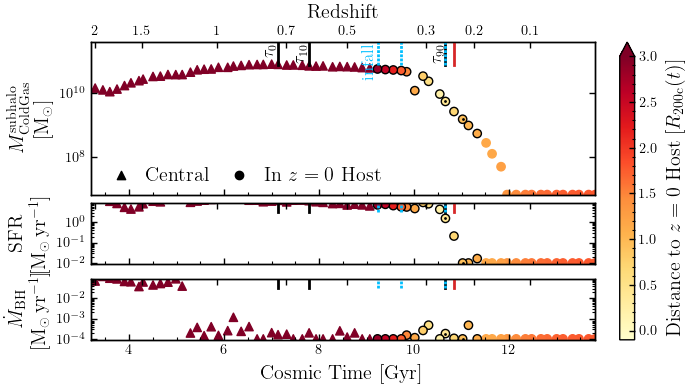

In [11]:
#key = '00063924'

fig, ax = plot_SCGM_evolution_multipanel(jel_dict_keys[0])
direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Documents/Conferences&Travel/20220905_EpochofQuenching_Cambridge/Figures/'
#fname = '%s_%03d_subfindID%s_SCGM-evolution_multipanel.pdf'%(sim, 99, key)
#fig.savefig(direc + fname, bbox_inches='tight')


In [34]:
def plot_SCGM_tracer_evolution_multipanel(jellyID):
    """
    Plot the SCGM as 3 panels
    """
    
    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[1., 1, 1]), figsize=(7.5, 5.5))
    
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    RPS_int_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_tot_kwargs = tau_kwargs.copy()
    tau_tot_kwargs['c'] = 'tab:pink'
    tau_tot_kwargs['lw'] = 3
    tau_est_kwargs = tau_kwargs.copy()
    tau_est_kwargs['ls'] = '-'
    tau_est_kwargs['lw'] = 4.0
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'tab:blue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    tau_quench_kwargs = tau_kwargs.copy()
    tau_quench_kwargs['c'] = 'tab:red'
    tau_quench_kwargs['lw'] = 2
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=axs[0].transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 7.0e6
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    axs[0].set_ylim(ylolim, yhilim)
    axs[0].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    for axis in axs:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == axs[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""

    # load data for the group
    group = jel_dict[jellyID]
    SnapNum = group['SnapNum']
    x = group[x_key].copy()
    y = group[y_key].copy()
    c = group[c_key].copy()
    
    y[y < ylolim] = ylolim
    
    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    ax = axs[0]
    
    jelly_indices = group['jel_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    done_indices  = group['ins_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=axs, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)
            
    # add a thin showing the integral of the RPS + outflows 
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    CosmicTimes = group['CosmicTime'].copy()
    time_diffs = np.ones(len(CosmicTimes), dtype=float)
    time_diffs[:-1] = (CosmicTimes[:-1] - CosmicTimes[1:]) * 1.0e9
    
    dset = np.cumsum((group[RPS_key].copy() * time_diffs)[::-1])[::-1]
    
    y = dset
    y[dset < ylolim] = ylolim
    ax.plot(x, y, **RPS_int_plot_kwargs)
    
    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_RPS_tot_infall']
    tau_vals = [0., 90., 99.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_tot_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == axs[0]:
                axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
                
    tau = group['tau_RPS_est_infall']
    tau_vals = [0., 90., 99.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        if tau_val == tau_vals[0]:
            index = min(np.where(tau == 0)[0])
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_est_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            #if axis == axs[0]:
            #    axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)

    # add a marker at the quenching time
    index = group['SnapNum'] == group['quenching_snap']
    if x[index] > xlolim:
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_quench_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))

    tau = group['tau_medpeak']
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in axs:
            axis.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                    transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            #if axis == axs[0] and tau_val == 0.:
            #    axis.text(xval-0.025, yhilim/1.25, r'medpeak', **tau_text_kwargs, color=tau_infall_kwargs['c'])
                    
    # add legend
    axs[0].legend(loc='lower left', ncol=2)
        
    # integral of RPS + outflows axis
    ax = axs[1]

    ax.set_ylabel(r'RPS + Outflows' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    dset = group[RPS_key].copy()
    
    ax.set_yscale('log')
    y_max = np.max(dset) * 3
    y_min = 9.0e-3
        
    y = dset
    y[dset < y_min] = y_min
    
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
    
    SFR = group['SubhaloSFR'].copy()
    SFR[SFR < y_min] = y_min
    ax.plot(x, SFR, **RPS_int_plot_kwargs)
    
    y = ru.RunningMedian(dset, 7)
    ax.plot(x, y, color='k', linewidth=2, marker='None', ls='-', alpha=1.0, zorder=3)
    
    # RPS axis
    ax = axs[2]

    ax.set_ylabel(r'RPS$ / M_{\rm ColdGas}^{\rm sat} $' '\n' r'$[{\rm yr^{-1}}]$', **axislabel_kwargs)
    RPS_key = 'SubhaloColdGasTracer_StripTot'
    SCGM_key = 'SubhaloColdGasMass'
    dset = group[RPS_key].copy() / group[SCGM_key].copy()
    plot_indices = group[SCGM_key] > 0
    
    ax.set_yscale('log')
    y_max = np.max(dset) * 3
    y_min = y_max * 1.0e-3
        
    y = dset
    y[dset < y_min] = y_min
    
    ax.plot(x[plot_indices & jelly_indices], y[plot_indices & jelly_indices], **jelly_kwargs)
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[plot_indices & indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[plot_indices & indices & done_indices], y[plot_indices & indices & done_indices], c=c[plot_indices & indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[plot_indices & indices & ~done_indices], y[plot_indices & indices & ~done_indices],
                        c=c[plot_indices & indices & ~done_indices], marker=marker, **sc_kwargs)        
        
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/Tracers/TNG50-1/'
    fname = '%s_snap-099_subfindID-%s_SCGM-tracer-evolution_multipanel.pdf'%(sim, jellyID)
    
    plt.savefig(direc + fname, bbox_inches='tight')
    
    plt.clf()
    
    return fig, ax


<IPython.core.display.Javascript object>


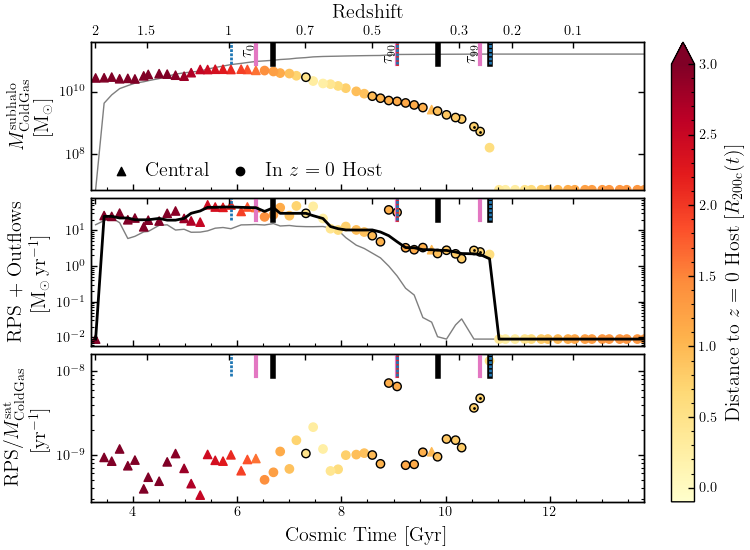

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:225: RuntimeWarning: invalid value encountered in true_divide


(<Figure size 750x550 with 7 Axes>,
 <AxesSubplot:xlabel='Cosmic Time [Gyr]', ylabel='RPS$ / M_{\\rm ColdGas}^{\\rm sat} $\n$[{\\rm yr^{-1}}]$'>)

In [35]:
for key in jel_dict_keys:
    _, _ = plot_SCGM_tracer_evolution_multipanelvolution_multipanel(key)

In [ ]:
for key in jel_dict_keys:
    fig, ax = plot_SCGM_tracer_evolution_multipanel(key)
    plt.close(fig)

In [ ]:
group = jel_dict[jel_dict_keys[100]]
infall_index = np.where(group['tau_infall'] == 0)[0][0] + 1
x_key = 'SubhaloSFR'
y_key = 'SubhaloColdGasTracer_StripTot'
x = ru.RunningMedian(group[x_key][infall_index:-1], 3)
y = ru.RunningMedian(group[y_key][infall_index:-1], 3)
indices = (group['SubfindID'][infall_index:-1] != -1) & (x != -1) & (y != -1)
eta = np.median(y[indices] / x[indices])
outflow_est = group[x_key][:infall_index+1] * eta 
RPS = group[y_key][:infall_index+1] - outflow_est

y_est = eta * x[indices]
y_err = (eta * x[indices] - y[indices]) / y[indices] * 100

fig, ax = plt.subplots()
ax.plot(x[indices], y[indices])
ax.plot(x[indices], y_est, 'k-')
ax.plot(x[indices], y_est - y[indices])

y_lolim = 5.0e-3
RPS[RPS < 0] = 0
RPS_cumsum = np.cumsum(RPS[::-1] * time_diffs[indices][::-1])[::-1]


fig, ax = plt.subplots()
ax.plot(group['CosmicTime'][:infall_index+1], RPS)
ax.plot(group['CosmicTime'][:infall_index+1], RPS_cumsum, 'k-')
ax.set_yscale('log')

In [ ]:
RPS_cumsum[infall_index]

In [ ]:
def plot_SCGM_evolution_sincez2(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    tau_quench_kwargs = tau_kwargs.copy()
    tau_quench_kwargs['c'] = 'tab:red'
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
            
    done_indices  = group['ins_flags'] == 1
    
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add outlines to the snapshots that are inspected
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs)        
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)
        
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jel_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    # add a marker for tau = 0 (peak cold gas mass)
    
    tau = group['tau_medpeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        text = ax.text(xval-0.04, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
        text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                               pe.Normal()])
    
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        if tau_val == 0.:
            ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])
            
    # add a marker at the quenching time
    index = group['SnapNum'] == jel_dict[key]['quenching_snap']
    if x[index] > xlolim:
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_quench_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        
    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    CosmicTime_tau0 = jel_taudict['CosmicTime_tau_medpeak0'][taudict_index]
    CosmicTime_infall = jel_taudict['CosmicTime_tau_infall0'][taudict_index]
    Tstrip_medpeak = jel_taudict['Tstrip_tau_medpeak_tau90-tau10'][taudict_index]
    Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r't(\tau_0) = %.1f\, [{\rm Gyr}],\ t({\rm infall}) = %.1f\, [{\rm Gyr}]&\\'%(CosmicTime_tau0, CosmicTime_infall) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'{\rm infall}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(Tstrip_infall) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='%s snap %03d \n subfindID %s'%(sim, snap, subfindID))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel/'

    fname = '%s_%03d_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    #fig.savefig(direc + fname, bbox_inches='tight')
    #fig.savefig(direc_ol + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
key = jel_dict_keys[1]

taudict_index = np.where(jel_dict_keys == key)[0]

fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)
direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Documents/Conferences&Travel/20220905_EpochofQuenching_Cambridge/Figures/'
fname = '%s_%03d_subfindID%s_SCGM-evolution.pdf'%(sim, 99, key)
#fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
sim = 'TNG100-1'
jel_dict, jel_SnapNum, jel_SubfindID = load_dict(sim, 'jellyfish')
jel_dict_keys = np.array(list(jel_dict.keys()))

jel_taudict = TNG100.tau_dict['jellyfish']

key = '00041636'
taudict_index = np.where(jel_dict_keys == key)[0]

fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)

In [ ]:
index = jel_dict[key]['SnapNum'] == jel_dict[key]['quenching_snap']
jel_dict[key]['CosmicTime'][index]

## Older code for making the SCGM plots + radial profile evolution

In [ ]:
# okay let's plot the cold gas mass evolution of a given satellite:
def plot_SCGM_evolution_sincez2(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, vmin=-0.1, vmax=3.0, s=6**2)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')

    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jelly_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    
    done_indices  = group['done_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        # add outlines to the snapshots that are inspected
        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs, label=label)
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0] - 1
    #jelly_indices = np.where(group['jelly_flags'] == 1)[0]

    #ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        text = ax.text(xval-0.04, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
        text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                               pe.Normal()])

    
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        #if tau_val == 0.:
        #    ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])



    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0'][taudict_index]
    CosmicTime_infall = jel_taudict['CosmicTime_tau_infall0'][taudict_index]
    Tstrip_medpeak = jel_taudict['Tstrip_tau_MedPeak_tau90-tau10'][taudict_index]
    Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r't(\tau_0) = %.1f\, [{\rm Gyr}],\ t({\rm infall}) = %.1f\, [{\rm Gyr}]&\\'%(CosmicTime_tau0, CosmicTime_infall) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'{\rm infall}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(Tstrip_infall) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='%s snap %03d \n subfindID %s'%(sim, snap, subfindID))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel_Sincez2/'

    fname = '%s_%s_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
#plt.close('all')

SnapNum_tau90   = jel_taudict['SnapNum_tau_MedPeak90']
SnapNum_tau0    = jel_taudict['SnapNum_tau_MedPeak0']
tau90_indices   = (SnapNum_tau90 != -1)
SnapNum_indices = SnapNum_tau0 >= 33.

CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
CosmicTime_indices = CosmicTime_tau0 > times[33]
jel_dict_keys_tau90_costime = jel_dict_keys[tau90_indices & CosmicTime_indices]
jel_dict_keys_tau90_snapnum = jel_dict_keys[tau90_indices & SnapNum_indices]

for key in jel_dict_keys:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)
    plt.close(fig)

In [ ]:
SnapNum_tau90   = jel_taudict['SnapNum_tau_MedPeak90']
SnapNum_tau0    = jel_taudict['SnapNum_tau_MedPeak0']
tau90_indices   = (SnapNum_tau90 != -1)
SnapNum_indices = SnapNum_tau0 >= 33.

CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
CosmicTime_indices = CosmicTime_tau0 > times[33]
jel_dict_keys_tau90_costime = jel_dict_keys[tau90_indices & CosmicTime_indices]
jel_dict_keys_tau90_snapnum = jel_dict_keys[tau90_indices & SnapNum_indices]

for key in jel_dict_keys_tau90_snapnum[0:1]:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution_sincez2(key, taudict_index)

In [ ]:
# okay let's plot the cold gas mass evolution of a given satellite:
def plot_SCGM_evolution(key, taudict_index):
    """
    Meant only for branches that have tau_0 at z <= 1 and reach tau_90 
    """
    
    fig, ax = plt.subplots()
               
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    dist_key = 'HostCentricDistance_phys'
    cmap = cm.get_cmap('YlOrRd')
    dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
    sc_kwargs = dict(cmap=cmap, vmin=-0.1, vmax=3.0, s=7**2)
    jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
    tau_medpeak_kwargs = tau_kwargs.copy()
    tau_infall_kwargs = tau_kwargs.copy()
    tau_infall_kwargs['c'] = 'deepskyblue'
    tau_infall_kwargs['ls'] = (0, (1, 0.5))
    
    tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='medium', transform=ax.transAxes, zorder=3)
    axislabel_kwargs = dict()
    #satlabel_kwargs = dict(ha='left', va='bottom', transform=ax.transAxes, fontsize='medium', ma='right')  
    
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 1.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)

    ax.set_yscale('log')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    ax.set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)
    ax.set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    ticks_SnapNum = [50, 59, 67, 78, 84, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['1', '0.7', '0.5', '0.3', '0.2', '0.1']
    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
    redshift_ax.set_xticklabels(ticks_labels)
    
    # load data for the group
    group = jel_dict[key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(r'Distance to $z=0$ Host [pkpc]', color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')

    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']
    
    # mark the snapshots that are classified as jellyfish
    jelly_indices = group['jelly_flags'] == 1
    ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)
    
    done_indices  = group['done_flags'] == 1

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = flags == 1
        # add outlines to the snapshots that are inspected
        ax.scatter(x[indices & done_indices], y[indices & done_indices], c=c[indices & done_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        sc = ax.scatter(x[indices & ~done_indices], y[indices & ~done_indices],
                        c=c[indices & ~done_indices], marker=marker, **sc_kwargs, label=label)
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]', **axislabel_kwargs)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0] - 1
    #jelly_indices = np.where(group['jelly_flags'] == 1)[0]

    #ax.plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_medpeak_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        ax.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)
    
    tau = group['tau_infall']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        ax.plot([xval, xval], [0.85, 1.0], **tau_infall_kwargs,
                transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
        #if tau_val == 0.:
        #    ax.text(xval-0.025, yhilim/1.25, r'infall', **tau_text_kwargs, color=tau_infall_kwargs['c'])

    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = jel_taudict['HostGroup_M_Crit200_z0'][taudict_index][0]
    SubhaloMstar_z0 = jel_taudict['Subhalo_Mstar_Rgal_z0'][taudict_index][0]
    CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0'][taudict_index]
    CosmicTime_infall = jel_taudict['CosmicTime_tau_infall0'][taudict_index]
    Tstrip_medpeak = jel_taudict['Tstrip_tau_MedPeak_tau90-tau10'][taudict_index]
    Tstrip_infall  = jel_taudict['Tstrip_tau_infall_tau90-tau10'][taudict_index]

    text = (r'\begin{align*}' +
            r't(\tau_0) = %.1f\, [{\rm Gyr}],\ t({\rm infall}) = %.1f\, [{\rm Gyr}]&\\'%(CosmicTime_tau0, CosmicTime_infall) + 
            r'M_{\rm 200c}^{\rm Host}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_z0, 2)) +
            r'M_{\star}^{\rm sat}(z=0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMstar_z0, 2)) +
            r'{\rm Peak}\ M_{\rm ColdGas}^{\rm sat}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}]  &\\ '%(Tstrip_medpeak) + 
            r'{\rm infall}\ \tau_{90} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(Tstrip_infall) + 
            r'\end{align*}')
    text = ax.text(0.99, 0.01, text, **tau0_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = key
    ax.legend(loc=(0.025, 0.05), title='%s snap %03d \n subfindID %s'%(sim, snap, subfindID))
               
    # ensure that the distance axis is behind the primary axis and that we 
    # can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/SinglePanel/'

    fname = '%s_%s_subfindID%s_SCGM-evolution.pdf'%(sim, snap, subfindID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
key = '00063924'
jel_dict_keys = TNG50.tau_dict_keys[TNG50.jel_key]
taudict_index = np.where(jel_dict_keys == key)[0]
fig, ax = plot_SCGM_evolution(key, taudict_index)

In [ ]:
#plt.close('all')
# let's get the list of branches that reach tau_90


SnapNum_tau90  = jel_taudict['SnapNum_tau_MedPeak90']
CosmicTime_tau0 = jel_taudict['CosmicTime_tau_MedPeak0']
tau90_indices = (SnapNum_tau90 != -1)
CosmicTime_indices = CosmicTime_tau0 > 6.
jel_dict_keys_tau90 = jel_dict_keys[tau90_indices & CosmicTime_indices]
for key in jel_dict_keys_tau90:
    taudict_index = np.where(jel_dict_keys == key)[0]
    fig, ax = plot_SCGM_evolution(key, taudict_index)
    plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'zooniverse_%s_jellyfish_branches.hdf5'%sim
with h5py.File('../Output/' + infname, 'r') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()       
    
zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
# load input file into a dictionary
def load_dict(sim, key):
    # key == 'jellyfish' or 'control'; otherwise returns KeyError
    result = {}
    fname = 'zooniverse_%s_%s_branches_clean.hdf5'%(sim, key)
    with h5py.File('../Output/' + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    # add arrays of the SnapNum and SubfindID separated already
    SnapNum = np.zeros(len(result.keys()), dtype=int)
    SubfindID = np.zeros(len(result.keys()), dtype=int)
    for i, key in enumerate(result.keys()):
        SnapNum[i] = int(key[:3])
        SubfindID[i] = int(key[4:])
    
    return result, SnapNum, SubfindID

jel_dict, jel_SnapNum, jel_SubfindID = load_dict(sim, 'jellyfish')


In [ ]:
newdict = {}
tau_vals = [0., 10., 90.]
grp_keys = ['SnapNum', 'CosmicTime', 'HostCentricDistance_norm', 'HostGroup_M_Crit200',
            'HostGroup_R_Crit200', 'HostSubhalo_Mstar_Rgal', 'SubhaloMass',
            'Subhalo_Mstar_Rgal', 'SubhaloColdGasMass']
tau_keys = ['tau_infall', 'tau_MedPeak']

for group_index, group_key in enumerate(grp_dict.keys()):
    group = grp_dict[group_key]
    
    # if just starting, then initialize the dictionary 
    if group_index == 0:
        newdict['SubfindID'] = np.zeros(len(grp_dict.keys()), dtype=int)
        for grp_key in grp_keys:
            for tau_key in tau_keys:
                for tau_val in tau_vals:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key] = np.zeros(len(grp_dict.keys()), 
                                                    dtype=group[grp_key].dtype)
    newdict['SubfindID'][group_index] = int(group_key)
    
    # for each of the definitions of tau, let's calculate important properties at tau_0, 
    for tau_key in tau_keys:
        tau = group[tau_key]
        for tau_val in tau_vals:
            if max(tau) < tau_val:
                for grp_key in grp_keys:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key][group_index] = -1

            else: 
                tau_index = max(np.argwhere((tau - tau_val) >= 0))
                for grp_key in grp_keys:
                    newdict_key = grp_key + '_' + tau_key + '%d'%tau_val
                    newdict[newdict_key][group_index] = group[grp_key][tau_index]                
    

In [ ]:
# how many jellyfish reach tau90?
tau90_medpeak_key = 'CosmicTime_tau_MedPeak90'
tau90_infall_key  = 'CosmicTime_tau_infall90'

tau90_medpeak = newdict[tau90_medpeak_key]
tau90_infall  = newdict[tau90_infall_key]

Njelly_tot = len(tau90_medpeak)
Ntau90_medpeak = len(np.where(tau90_medpeak < 0)[0])
Ntau90_infall = len(np.where(tau90_infall < 0)[0])
print(Njelly_tot, Ntau90_medpeak, Ntau90_infall)


In [ ]:
# how many jellyfish are their own z=0 host?
hostdist_key = 'HostCentricDistance_norm_tau_infall0'
hostdist = newdict[hostdist_key]
Nhostdist0 = len(np.where(hostdist == 0.)[0])
print(Nhostdist0)

In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key = 'HostGroup_M_Crit200_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Sub})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c = newdict[c_key]
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s.pdf'%(x_key, y_key, c_key, sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Subhal})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c = newdict[c_key]
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s.pdf'%(x_key, y_key, c_key, sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
x_key = 'CosmicTime_tau_MedPeak0'
y_key = 'CosmicTime_tau_infall0'
c_key1 = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
c_key2 = 'HostGroup_M_Crit200_tau_MedPeak0'

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_0 = {\rm Cosmic\ Time\ at\  max}(M_{\rm ColdGas}^{\rm Subhal})$ [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.set_ylabel(r'Infall time [Gyr]')
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')

x = newdict[x_key]
y = newdict[y_key]
c1 = newdict[c_key1]
c2 = newdict[c_key2]
c = c1/c2
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_\star^{\rm Subhalo}(\tau_0) / M_{\rm 200c}^{\rm Host}(\tau_0)$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = '%s_%s_%s_%s-%s.pdf'%(x_key, y_key, c_key1, c_key2, sim)
#fig.savefig(direc+fname, bbox_inches='tight')



In [ ]:
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak0']
y = newdict['CosmicTime_tau_infall0']

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 14., 0.5)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_0 = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_0 = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$\tau_0$ [Gyr]')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau0_infalltimes_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


The infall times are typically similar or larger than $\tau_0$. 

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
indices_medpeak = np.where(newdict[key_medpeak90] > 0)[0]
indices_infall = np.where(newdict[key_infall90] > 0)[0]
print(len(newdict[key_infall90]), len(indices), len(indices_medpeak), len(indices_infall))
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices_medpeak] - newdict['CosmicTime_tau_MedPeak10'][indices_medpeak]
y = newdict['CosmicTime_tau_infall90'][indices_infall] - newdict['CosmicTime_tau_infall10'][indices_infall]

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 14., 0.5)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_{0} = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_{0} = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$\tau_{90} - \tau_{10}$ [Gyr]')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau10_infalltimes_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')



In [ ]:
newdict.keys()

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'HostGroup_M_Crit200_z0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak10'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices]
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_m200chost_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['CosmicTime_tau_infall90'][indices] - newdict['CosmicTime_tau_infall0'][indices]
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_mstarsubhalo_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
key_infall90 = 'CosmicTime_tau_infall90'
indices = np.where((newdict[key_infall90] > 0) & (newdict[key_medpeak90] > 0))[0]
c_key1 = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
c_key2 = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['CosmicTime_tau_infall90'][indices] - newdict['CosmicTime_tau_infall0'][indices]
c1 = newdict[c_key1][indices]
c2 = newdict[c_key2][indices]
c = c1/c2

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_aspect('equal')
ax.set_xlim(0., 14.)
ax.set_ylim(0., 14.)
ax.plot([0., 14.], [0., 14.], ls='-', marker='None', c='k')
ax.set_ylabel(r'$\tau_{90} - \tau_0$ [Infall Time] [Gyr]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_\star^{\rm Subhalo}(\tau_0) / M_{\rm 200c}^{\rm Host}(\tau_0)$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_tau90-tau0-infall_mstarsubhalo-m200chost_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
#c_key = 'HostGroup_M_Crit200_tau_MedPeak0'
x = newdict['HostCentricDistance_norm_tau_MedPeak0']
y = newdict['HostCentricDistance_norm_tau_infall0']

x_weights = np.ones(len(x)) / float(len(x)) * 100.
y_weights = np.ones(len(y)) / float(len(y)) * 100.

bins = np.arange(0., 6.25, 0.25)
fig, ax = plt.subplots()
ax.hist(x, bins, histtype='step', lw=4, align='mid', weights=x_weights, label=r'$\tau_0 = {\rm max}\left(M_{\rm ColdGas}^{\rm Subhalo}\right)$')
ax.hist(y, bins, histtype='step', lw=4, align='mid', weights=y_weights, label=r'$\tau_0 = {\rm Infall\ Time}$', color='tab:blue')
ax.set_xlabel(r'$d_0\ [R_{\rm 200c}^{\rm LIHost}(\tau_0)]$')
ax.set_ylabel(r'Percentage')
ax.legend(fontsize='large')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'd0_histogram_%s'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
max(x), max(y), np.median(x), np.median(y), np.mean(x), np.mean(y), len(x[x > 6]), len(y[y > 6]), len(y[y == 0])

In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'HostGroup_M_Crit200_z0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak10'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices] 
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_{10}$ [Gyr]')
ax.set_xlim(0., 10.)
ax.set_ylim(1.0e-2, 1.0e2)
ax.set_yscale('log')
ax.set_ylabel(r'$d_{90}$ [$R_{\rm 200c}^{\rm Host}(\tau_{90})$]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\rm 200c}^{\rm Host}(z=0)\, [{\rm M_\odot}]$')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
direc_desk = '/Users/rohr/Desktop/'
fname = 'tau90-tau0-medpeak_d90_m200chost_%s.pdf'%(sim)
fig.savefig(direc_desk+fname, bbox_inches='tight')


In [ ]:
key_medpeak90 = 'CosmicTime_tau_MedPeak90'
indices = np.where(newdict[key_medpeak90] > 0)[0]
c_key = 'Subhalo_Mstar_Rgal_tau_MedPeak0'
x = newdict['CosmicTime_tau_MedPeak90'][indices] - newdict['CosmicTime_tau_MedPeak0'][indices]
y = newdict['HostCentricDistance_norm_tau_MedPeak90'][indices] 
c = newdict[c_key][indices]

fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau_{90} - \tau_0$ [peak $M_{\rm ColdGas}^{\rm Subhalo}$] [Gyr]')
ax.set_xlim(0., 10.)
ax.set_ylim(1.0e-2, 1.0e2)
ax.set_yscale('log')
ax.set_ylabel(r'$d_{90}$ [$R_{\rm 200c}^{\rm Host}(\tau_{90})$]')
sc = ax.scatter(x, y, c=c, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$M_{\star}^{\rm Subhalo}(\tau_0)\, [{\rm M_\odot}]$')
direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Figures/'
fname = 'tau90-tau0-medpeak_d90_mstarsubhalo_%s.pdf'%(sim)
#fig.savefig(direc+fname, bbox_inches='tight')


In [ ]:
done_lens = np.zeros(len(grp_dict.keys()))
jelly_lens = np.zeros(len(grp_dict.keys()))
for index, key in enumerate(grp_dict.keys()):
    jelly = grp_dict[key]
    done_lens[index] = len(np.where(jelly['done_flags'] == 1)[0])
    jelly_lens[index] = len(np.where(jelly['jelly_flags'] == 1)[0])


In [ ]:
np.argmax(jelly_lens)
jelly_lens[282]


In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Number of Snapshots Classified as a Jellyfish')
ax.set_ylabel(r'Number of Objects')
ax.set_xlim(0, 30)
ax.text(0.9725, 0.9725, r'%s'%sim, ha='right', va='top', transform=ax.transAxes, fontsize='large')

def tick_func(N):
    deltat = N * 0.15 # [Gyr] the mean separation between snapshots
    return ['%.2f' % t for t in deltat]

new_tick_locations = np.array([0, 5, 10, 15, 20, 25, 30])
tick_labels = tick_func(new_tick_locations)
deltat_ax = ax.twiny()
deltat_ax.set_xlim(ax.get_xlim())
deltat_ax.set_xticks(new_tick_locations)
deltat_ax.set_xticklabels(tick_labels)
deltat_ax.set_xlabel(r'Total Time Classified as a Jellyfish [Gyr]')


bins = range(30)
ax.hist(jelly_lens, bins, histtype='step', lw=4, log=True, align='mid')

direc = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/JellyfishEvolution/Histograms/'
fname = '%s_JellyfishDuration_Histogram.pdf'%sim
#fig.savefig(direc + fname, bbox_inches='tight')


In [ ]:
ax.get_xticks(), deltat_ax.get_xticks()

In [ ]:
### from 2021-11-22: didn't get it to work... TBD
"""
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
from matplotlib.ticker import AutoMinorLocator
header = il.groupcat.loadHeader(basePath, snap)
cosmo = FlatLambdaCDM(header['HubbleParam'] * 100., header['Omega0'])

def forward(t):
    return np.interp(t, times[::-1], redshifts[::-1])

def inverse(z):
    return np.interp(z, redshifts, times)

plt.close('all')

fig, ax = plt.subplots()

times = group['CosmicTime']
redshifts = group['Redshift']
SCGM = group['SubhaloColdGasMass']
ax.set_yscale('log')

ax.set_xlabel(r'Cosmic Time')

ax.plot(times, SCGM)
ax.set_xlim(min(times), max(times))

secxax = ax.secondary_xaxis('top', functions=(forward, inverse))
secxax.set_xlabel(r'Redshift')
secxax.xaxis.set_minor_locator(AutoMinorLocator())
secxax.set_xscale('log')
ax.tick_params(axis='x', which='both', top=False)
"""

In [ ]:
def plot_SCGM_evolution(jellyID):
    x_key = 'CosmicTime'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    cmap = cm.get_cmap('YlOrRd')
    sc_kwargs = dict(cmap=cmap, vmin=-0.25, vmax=4.0, s=8**2)
    done_kwargs = dict(marker='+', c='k', ms=2, mew=1, fillstyle='full')
    jelly_kwargs = dict(marker='*', c='k', ms=10, mew=1, fillstyle='none')
    tau_kwargs = dict(c='k', lw=2, ls='-', marker='None')
    tau_text_kwargs = dict(ha='right', va='top', rotation=90)
    axislabel_kwargs = dict()
    ylolim = 1.1e4
    yhilim = 3.9e11
    xlolim = -.1
    xhilim = 14.

    # start figure -- add labels and limits
    fig, ax = plt.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[2.5, 1, 1]))
    
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$')
    ax[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    ax[0].set_ylim(ylolim, yhilim)
    ax[0].set_xlim(xlolim, xhilim)

    # add second x axis for redshift
    # we want to add tickmarks at specified redshifts: z = 10, 5, 2, 1, 0.5, 0.2, 0.1
    # so we can use the SnapNum corresponding to these redshifts, and use these
    # to retrieve the cosmic time at these snapshots, giving cosmic time -> redshift
    #"""
    ticks_SnapNum = [4, 17, 33, 50, 67, 91]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['10', '5', '2', '1', '0.5', '0.1']
    for axis in ax:
        redshift_ax = axis.twiny()
        redshift_ax.set_xlim(axis.get_xlim())
        redshift_ax.set_xticks(ticks_costime)
        redshift_ax.tick_params(axis='both', which='minor', top=False)
        if axis == ax[0]:
            redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
            redshift_ax.set_xticklabels(ticks_labels)
        else:
            redshift_ax.set_xticklabels([])
    #"""

    # load data for the group
    group = jel_dict[jellyID]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    c = group[c_key]
    
    flag_keys = ['CentralFlags', 'PreProcessedFlags', 'MemberLIFoFFlags']
    labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
    markers = ['^', 's', 'o']

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[0].scatter(x[indices], y[indices], c=c[indices], marker=marker, **sc_kwargs, label=label)

    # add markers for when the subhalo was classified, and as a jelly
    done_indices = np.where(group['done_flags'] == 1)[0]
    jelly_indices = np.where(group['jelly_flags'] == 1)[0]
    #ax[0].plot(x[done_indices], y[done_indices], **done_kwargs)
    ax[0].plot(x[jelly_indices], y[jelly_indices], **jelly_kwargs)

    # add a marker for tau = 0 (peak cold gas mass)
    tau = group['tau_MedPeak']
    tau_vals = [0., 10., 90.]
    for tau_val in tau_vals:
        # check that the subhalo actually loses at least tau_val% of the cold gas
        if max(tau) < tau_val:
            break
        index = max(np.argwhere((tau - tau_val) >= 0))
        xval = x[index]
        for axis in ax:
            axis.plot([xval, xval], [0.85, 1.0], **tau_kwargs,
                      transform=transforms.blended_transform_factory(axis.transData, axis.transAxes))
            if axis == ax[0]:
                axis.text(xval-0.025, yhilim/1.25, r'$\tau_{%d}$'%tau_val, **tau_text_kwargs)

    # add extra info about and at tau_0 
    tau0_index = np.argmin(abs(tau))
    M200c_host_tau0 = group['HostGroup_M_Crit200'][tau0_index]
    SubhaloMass_tau0 = group['SubhaloMass'][tau0_index]
    CosmicTime_tau0 = x[tau0_index]
    Redshift_tau0 = group['Redshift'][tau0_index]

    tau10_index = max(np.argwhere((tau - 10.) >= 0.))
    # calculate tau_90 - tau_10 as the characteristic stripping timescale 
    tau_crit = 90
    while max(tau) < tau_crit:
        tau_crit -= 10
    tau_val = x[max(np.argwhere((tau - tau_crit) >= 0))]
    tau_crit_0  = tau_val - x[tau10_index]
    text = (r'\begin{align*}' +
            r't(\tau_0) = %.2f\, [{\rm Gyr}],\ z(\tau_0) = %.2f &\\'%(CosmicTime_tau0, Redshift_tau0) + 
            r'M_{\rm 200c}^{\rm LIHost}(\tau_0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(M200c_host_tau0, 2)) +
            r'M_{\rm tot}^{\rm sub}(\tau_0) = %s\, [{\rm M_\odot}] &\\'%(ru.latex_float(SubhaloMass_tau0, 2)) +
            r'\tau_{%2d} - \tau_{10} = %.2f\, [{\rm Gyr}] &'%(tau_crit, tau_crit_0) + 
            r'\end{align*}')
    tau0_text_kwargs = dict(ha='right', va='bottom', fontsize='small', transform=ax[0].transAxes)
    ax[0].text(0.975, 0.025, text, **tau0_text_kwargs)

    # add legend
    ax[0].legend(loc=(0.1, 0.05))
        
    # SFR axis
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'SFR' '\n' r'$ [{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    ax[1].set_ylim(9e-3, 9e0)
    SFR = group['SubhaloSFR']
    SFR[SFR <= 1.0e-2] = 1.0e-2
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[1].scatter(x[indices], SFR[indices], c=c[indices], marker=marker, **sc_kwargs)
        
    # BHMdot axis
    ax[2].set_yscale('log')
    ax[2].set_ylim(9e-5, 9e-2)
    ax[2].set_ylabel(r'$\dot{M}_{\rm BH}$' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)
    BHMdot = group['SubhaloBHMdot']
    BHMdot[BHMdot <= 1.0e-4] = 1.0e-4
    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key]
        indices = np.argwhere(flags == 1)
        sc = ax[2].scatter(x[indices], BHMdot[indices], c=c[indices], marker=marker, **sc_kwargs)

        # add colorbar once
        if flag_index == 0:
            cbar = fig.colorbar(sc, ax=ax, extend='max')
            cbar.set_label(r'Distance to Last Identified Host [$R_{\rm 200c}$]', **axislabel_kwargs)
    
    label_kwargs = dict(ha='right', va='top', transform=ax[-1].transAxes, fontsize='small',
                        ma='right')        
    ax[-1].text(0.975, 0.85, '%s snap 099 \n subfindID %s'%(sim, jellyID),
                **label_kwargs)
    # adjust the figure size to see the title
    #plt.subplots_adjust(hspace=0.05)
    
    direc = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/JellyfishEvolution/'
    fname = '%s_snap099_subfindID%s.pdf'%(sim, jellyID)
    
    #plt.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


In [ ]:
for key in jel_dict_keys:
    fig, ax = plot_SCGM_evolution(key)
    plt.close(fig)

In [ ]:
plot_SCGM_evolution('094_00069001')

In [ ]:
# load the preprocessed keys
import random
number_plots = 50
indirec = '../Output/'
infname = 'TNG50_zooniverse_preprocessedkeys.txt'
keys = open(indirec + infname, 'r').read().split('\n')[:-1]
for key in random.sample(keys, 50):
    fix, ax = plot_SCGM_evolution(key)

In [ ]:
fig, ax = plot_SCGM_evolution('033_00000014')

In [ ]:
#plt.close('all')
key = '094_00069001'
fig, ax = plot_SCGM_evolution(key)


In [ ]:
jelly_dict = grp_dict[key]
jelly_dict['']

In [ ]:
jelly_keys = list(grp_dict.keys())
for jellyID in jelly_keys[431:432]:
    fig, ax = plot_SCGM_evolution(jellyID)


In [ ]:
#plt.show()
plt.close(fig)

In [ ]:
#plt.close('all')
jelly_keys = list(grp_dict.keys())
for jellyID in jelly_keys[430:440]:
    fig, ax = plot_SCGM_evolution(jellyID)
    plt.close(fig)

In [ ]:
jelly = grp_dict[jellyID]
jelly['jelly_flags']

In [ ]:
plt.close('all')
for jellyID in grp_dict.keys():
    fig, ax = plot_SCGM_evolution(jellyID)
    plt.close(fig)


In [ ]:


for jellyID in grp_dict.keys():

    x_key = 'SnapNum'
    y_key = 'SubhaloColdGasMass'
    c_key = 'HostCentricDistance_norm'
    cmap = cm.get_cmap('YlOrRd')

    jelly_dict = grp_dict[jellyID]
    x = times[jelly_dict[x_key]]
    y = jelly_dict[y_key]
    c = jelly_dict[c_key]

    fig, ax = plt.subplots()
    sc = ax.scatter(x, y, c=c, cmap=cmap, vmin=-0.25, vmax=4.0)
    cbar = plt.colorbar(sc, extend='max')
    cbar.set_label(r'Distance to Last Identified Host [$R_{\rm 200c}$]')
    ax.set_yscale('log')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm Jelly}\, [{\rm M_\odot}]$')
    ax.set_xlabel(r'Cosmic Time [Gyr]')
    ax.set_ylim(1.0e6, 5.0e10)


In [ ]:
times[x], x

In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfish-evolution_%s_%s.hdf5'%(sim, str(snap).zfill(3))
with h5py.File('../Output/' + infname, 'r') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dset_key in f[group_key].keys():
            grp_dict[group_key][dset_key] = f[group_key][dset_key][:]
    f.close()       
    
zs, times = ru.timesfromsnap(basePath, range(100))
times /= 1.0e9 # [Gyr]
scales = 1. / (1. + zs)

In [ ]:
y_key = 'SubhaloColdGasMass'
c_key = 'HaloCentricDistance_Norm'
cmap = cm.get_cmap('YlOrRd')

for jellyID in grp_dict.keys():
    jelly_dict = grp_dict[jellyID]
    xs = np.zeros(len(jelly_dict.keys()))
    ys = np.zeros(len(jelly_dict.keys()))
    cs = np.zeros(len(jelly_dict.keys()))

    for snap_index, snap_key in enumerate(jelly_dict.keys()):
        xs[snap_index] = (int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
        ys[snap_index] = (jelly_dict[snap_key][y_key])
        cs[snap_index] = (jelly_dict[snap_key][c_key])

    fig, ax = plt.subplots()
    ax.set_xlabel('Snaps Since Infall')
    ax.set_ylabel(r'$M_{\rm ColdGas}^{\rm Jelly}\, [{\rm M_\odot}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_yscale('log')
    sc = ax.scatter(xs, ys, c=cs, cmap=cmap)
    cbar = plt.colorbar(sc)
    cbar.set_label(r'Halo Centric Distance [$R_{\rm vir}$]')
    ax.set_ylim(0.5 * min(ys[ys > 0]), 2.0 * max(ys))


In [ ]:
x_key = 'radii'
y_key = 'mass_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm ColdGas}^{\rm Jelly}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfishgasradprof_%s_%s_radii-binwidth-%s-%.2f_allgas.hdf5'%(sim, snap, bin_str, radii_binwidth)
with h5py.File('../Output/' + infname, 'a') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dict_key in f[group_key]:
            grp_dict[group_key][dict_key] = {}
            for dset_key in f[group_key][dict_key]:
                grp_dict[group_key][dict_key][dset_key] = f[group_key][dict_key][dset_key][:]
    f.close()            

x_key = 'radii'
y_key = 'densities_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm AllGas}^{\rm Jelly}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution_allgas.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)


In [ ]:
# load input file into a dictionary
sim = 'TNG50-1'
snap = 67
tlim = 10.**(4.5) # K; cutoff between cold and hot CGM gas
basePath = ru.ret_basePath(sim)
bin_str = 'rgalnorm'
radii_binwidth = 0.1

# load the gas radial profiles for the jellyfish
grp_dict = {}
infname = 'rohr_jellyfishgasradprof_%s_%s_radii-binwidth-%s-%.2f_FoF.hdf5'%(sim, snap, bin_str, radii_binwidth)
with h5py.File('../Output/' + infname, 'a') as f:
    for group_key in f.keys():
        grp_dict[group_key] = {}
        for dict_key in f[group_key]:
            grp_dict[group_key][dict_key] = {}
            for dset_key in f[group_key][dict_key]:
                grp_dict[group_key][dict_key][dset_key] = f[group_key][dict_key][dset_key][:]
    f.close()            

x_key = 'radii'
y_key = 'densities_shells'
cmap = cm.get_cmap('YlOrRd')
kwargs_ml = {'lw':1, 'ls':'-', 'alpha':1}

for jellyID in grp_dict.keys():

    jelly_dict = grp_dict[jellyID]

    xs = []
    ys = []
    cs = []
    for snap_key in jelly_dict.keys():
        if snap_key == list(jelly_dict.keys())[-1]:
            continue
        indices = np.where([jelly_dict[snap_key][y_key] > 0])[1]
        xs.append(jelly_dict[snap_key][x_key][indices])
        ys.append(jelly_dict[snap_key][y_key][indices])
        cs.append(int(snap_key) - int(list(jelly_dict.keys())[0]) - 10)
    

    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel(r'$R\, [{\rm pkpc}]$')
    ax.set_ylabel(r'$\rho_{\rm ColdGas}^{\rm FoF}({\rm shell})\, [{\rm M_\odot\, kpc^{-3}}]$')
    ax.set_title(r'%s snap %03d jellyID %08d'%(sim, snap, int(jellyID)))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(8.0e-2, 2.0e2)
    ax.set_ylim(7.0e-3, 2.0e9)

    lc = ru.multiline(xs, ys, cs, cmap=cmap, **kwargs_ml)
    cbar = fig.colorbar(lc)
    cbar.set_label(r'Snaps since infall')
    
    outfname = 'rho_r-rgal_evolution_FoF.pdf'
    outdirec = '../Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    outdirec2 = '/Users/rohr/Dropbox/Rohr_Pillepich/Figures/GasMaps/jellyfish-evolution_%s_%03d/%d/'%(sim, snap, int(jellyID))
    #fig.savefig(outdirec + outfname, bbox_inches='tight')
    #fig.savefig(outdirec2+ outfname, bbox_inches='tight')
    #plt.close(fig)
